# Data Preprocessing

We have a total of 10753 songs, for which Mel-spectrograms and Spotify tags are provided.  
  
MRC Genres - ?  
AppleMusic Genres - ?  
  
Additonally, 440873 rows from YT reports are given. There are 41 data points(rows) per song, concerning years 2019/01/01 - 2022/05/01. Each of them shows the Release date, as well as the Total and Peak Views of the music video of the song.  
  
All songs came out during the time period 2017/01/01 - 2018/12/31.  

(GPU NVIDIA RTX 3060 12GB RAM
CPU AMD Ryzen 9 3900X 12-Core Processor)

## Imports 

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
from os import listdir

import re
from functools import reduce
import pickle
import librosa
import numpy as np
import pandas as pd
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 32})
plt.rcParams['figure.figsize'] = (18,6)
plt.style.use('ggplot')
sns.set_style("darkgrid")
pd.set_option("display.max_rows", None)

from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import librosa.display

from tensorflow.keras.preprocessing.text import one_hot
#from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#from tsfresh import extract_features, select_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters

## Youtube Reports - Views 

In [2]:
popularity = pd.read_csv('popularity.csv')
popularity['DATE'] = pd.to_datetime(popularity[['YEAR', 'MONTH']].assign(DAY=1), format = "%d%m%Y") #ignored
print(f"There are {popularity.shape[0]} total rows with {popularity.shape[1]} columns each for a total of {popularity.id.nunique()} songs. We have 0 NA values.")
popularity.head()

There are 462603 total rows with 7 columns each for a total of 11283 songs. We have 0 NA values.


id  MONTH  YEAR release_date  \
0  190295742980-de5d788df875b44c7e10491d98daf0a8      7  2020   2017-05-08   
1  190295742980-de5d788df875b44c7e10491d98daf0a8      7  2021   2017-05-08   
2  190295742980-de5d788df875b44c7e10491d98daf0a8      8  2021   2017-05-08   
3  190295742980-de5d788df875b44c7e10491d98daf0a8      2  2019   2017-05-08   
4  190295742980-de5d788df875b44c7e10491d98daf0a8      6  2020   2017-05-08   

   TOTAL_VIEWS  PEAK_VIEWS       DATE  
0         1213         130 2020-07-01  
1          349         164 2021-07-01  
2          397         172 2021-08-01  
3           12           7 2019-02-01  
4         1809         202 2020-06-01

### Closer look into views of specific song (id=190296919015-6a75ff6818c16f56455540d3d8f849b7):

In [4]:
popularity[popularity.id == popularity.id[213282]]

id  MONTH  YEAR  \
213282  190296919015-6a75ff6818c16f56455540d3d8f849b7      3  2020   
213283  190296919015-6a75ff6818c16f56455540d3d8f849b7      1  2020   
213284  190296919015-6a75ff6818c16f56455540d3d8f849b7      8  2020   
213285  190296919015-6a75ff6818c16f56455540d3d8f849b7      6  2020   
213286  190296919015-6a75ff6818c16f56455540d3d8f849b7      6  2021   
213287  190296919015-6a75ff6818c16f56455540d3d8f849b7     10  2021   
213288  190296919015-6a75ff6818c16f56455540d3d8f849b7      4  2020   
213289  190296919015-6a75ff6818c16f56455540d3d8f849b7      1  2021   
213290  190296919015-6a75ff6818c16f56455540d3d8f849b7      7  2019   
213291  190296919015-6a75ff6818c16f56455540d3d8f849b7      1  2022   
213292  190296919015-6a75ff6818c16f56455540d3d8f849b7     11  2021   
213293  190296919015-6a75ff6818c16f56455540d3d8f849b7     10  2020   
213294  190296919015-6a75ff6818c16f56455540d3d8f849b7      1  2019   
213295  190296919015-6a75ff6818c16f56455540d3d8f849b7      7  2020   
213296  190296919015-6a75ff6818c16f56455540d3d8f849b7      2  2019   
213297  190296919015-6a75ff6818c16f56455540d3d8f849b7      5  2021   
213298  190296919015-6a75ff6818c16f56455540d3d8f849b7      9  2019   
213299  190296919015-6a75ff6818c16f56455540d3d8f849b7      8  2019   
213300  190296919015-6a75ff6818c16f56455540d3d8f849b7     10  2019   
213301  190296919015-6a75ff6818c16f56455540d3d8f849b7      4  2021   
213302  190296919015-6a75ff6818c16f56455540d3d8f849b7      3  2022   
213303  190296919015-6a75ff6818c16f56455540d3d8f849b7     12  2021   
213304  190296919015-6a75ff6818c16f56455540d3d8f849b7      5  2020   
213305  190296919015-6a75ff6818c16f56455540d3d8f849b7      2  2020   
213306  190296919015-6a75ff6818c16f56455540d3d8f849b7      9  2020   
213307  190296919015-6a75ff6818c16f56455540d3d8f849b7      2  2021   
213308  190296919015-6a75ff6818c16f56455540d3d8f849b7      4  2019   
213309  190296919015-6a75ff6818c16f56455540d3d8f849b7      7  2021   
213310  190296919015-6a75ff6818c16f56455540d3d8f849b7      9  2021   
213311  190296919015-6a75ff6818c16f56455540d3d8f849b7      4  2022   
213312  190296919015-6a75ff6818c16f56455540d3d8f849b7      5  2022   
213313  190296919015-6a75ff6818c16f56455540d3d8f849b7      3  2021   
213314  190296919015-6a75ff6818c16f56455540d3d8f849b7     12  2019   
213315  190296919015-6a75ff6818c16f56455540d3d8f849b7     11  2019   
213316  190296919015-6a75ff6818c16f56455540d3d8f849b7      8  2021   
213317  190296919015-6a75ff6818c16f56455540d3d8f849b7      2  2022   
213318  190296919015-6a75ff6818c16f56455540d3d8f849b7      5  2019   
213319  190296919015-6a75ff6818c16f56455540d3d8f849b7      3  2019   
213320  190296919015-6a75ff6818c16f56455540d3d8f849b7     12  2020   
213321  190296919015-6a75ff6818c16f56455540d3d8f849b7      6  2019   
213322  190296919015-6a75ff6818c16f56455540d3d8f849b7     11  2020   

       release_date  TOTAL_VIEWS  PEAK_VIEWS       DATE  
213282   2018-09-12    115005461     1210231 2020-03-01  
213283   2018-09-12    223870439     2328545 2020-01-01  
213284   2018-09-12    145200685     3044245 2020-08-01  
213285   2018-09-12     91525102     1427425 2020-06-01  
213286   2018-09-12     60985341     3400406 2021-06-01  
213287   2018-09-12     38863648     1840226 2021-10-01  
213288   2018-09-12    152666024     1558906 2020-04-01  
213289   2018-09-12    116583787     4260205 2021-01-01  
213290   2018-09-12     32042666      675154 2019-07-01  
213291   2018-09-12     68322234     1218916 2022-01-01  
213292   2018-09-12     47961627     1782717 2021-11-01  
213293   2018-09-12     86753097     2637869 2020-10-01  
213294   2018-09-12      5713411      279795 2019-01-01  
213295   2018-09-12    114369324     2296398 2020-07-01  
213296   2018-09-12      8980885      280358 2019-02-01  
213297   2018-09-12     55364519     1459217 2021-05-01  
213298   2018-09-12     64400896      769832 2019-09-01  
213299   2018-09-12     36977316      523116 2019-08-01  
213300  

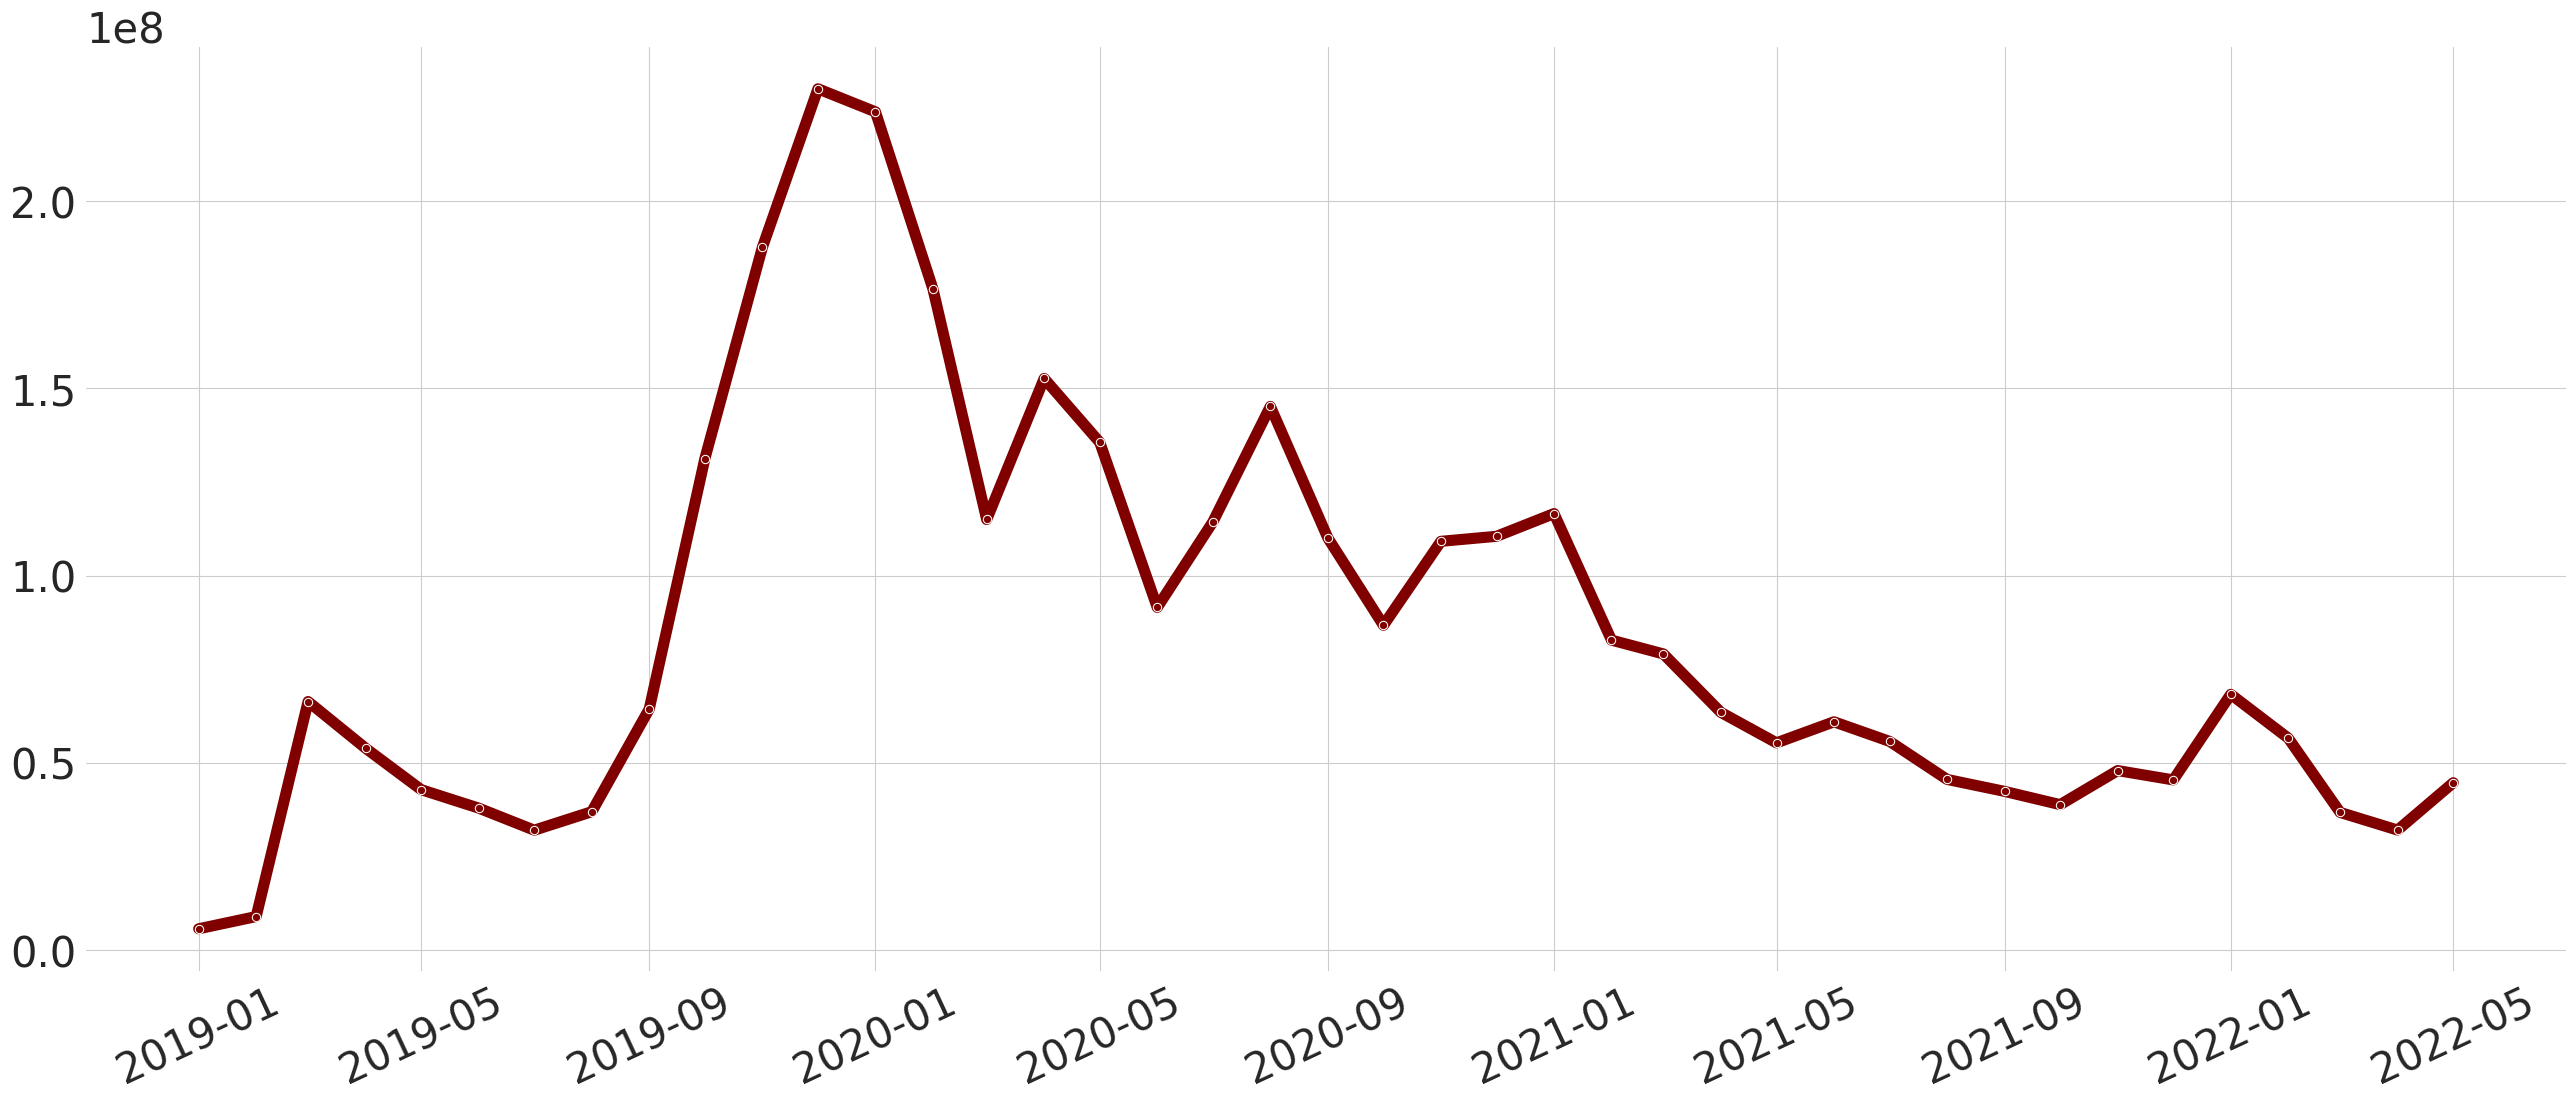

In [18]:
#Plot progress of one song
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(32,12))
plt.xticks(rotation = 25)

plot_data = popularity[popularity.id == popularity.id[213282]] #song of choice
fig = sns.lineplot(x = 'DATE', y  = 'TOTAL_VIEWS', data = plot_data, linewidth=8,
            marker='o', c='maroon') #.set(title='Total views of a song per month from years 2019-2022');
plt.xlabel("");
plt.ylabel(""); #Total Views (in hundrends of millions)
sns.despine(left=True, bottom=True)

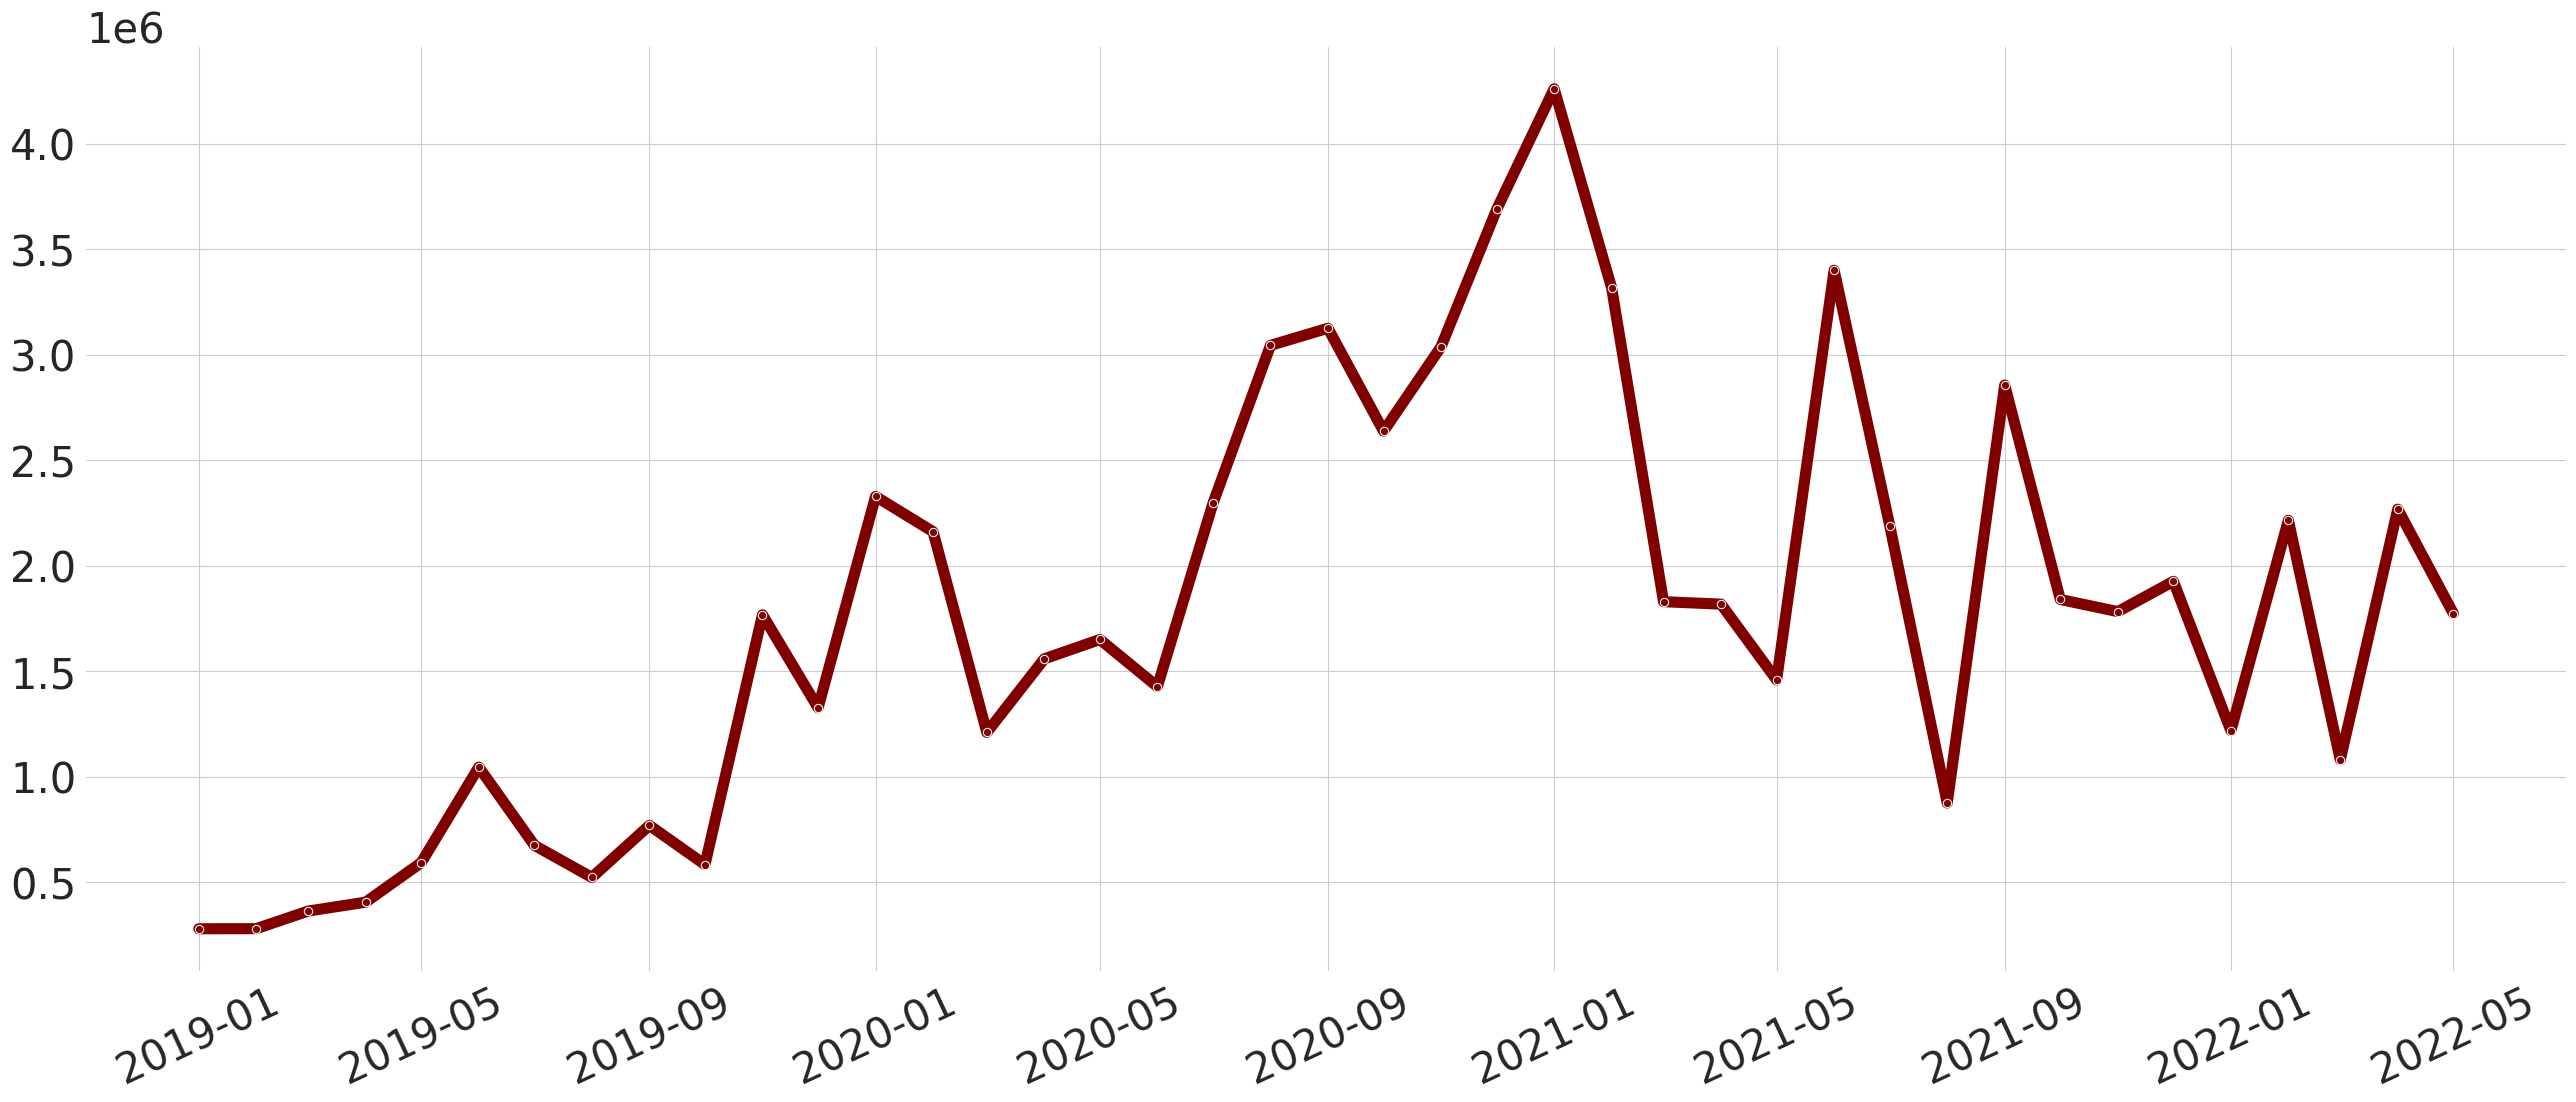

In [20]:
#Plot progress of one song
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(32,12))
plt.xticks(rotation = 25)

plot_data = popularity[popularity.id == popularity.id[213282]] #song of choice
fig = sns.lineplot(x = 'DATE', y  = 'PEAK_VIEWS', data = plot_data, linewidth=8,
            marker='o',  c='maroon') #.set(title='Peak views of a song per month from years 2019-2022');
plt.xlabel("");
plt.ylabel("");
sns.despine(left=True, bottom=True)

Visualization of Coefficients

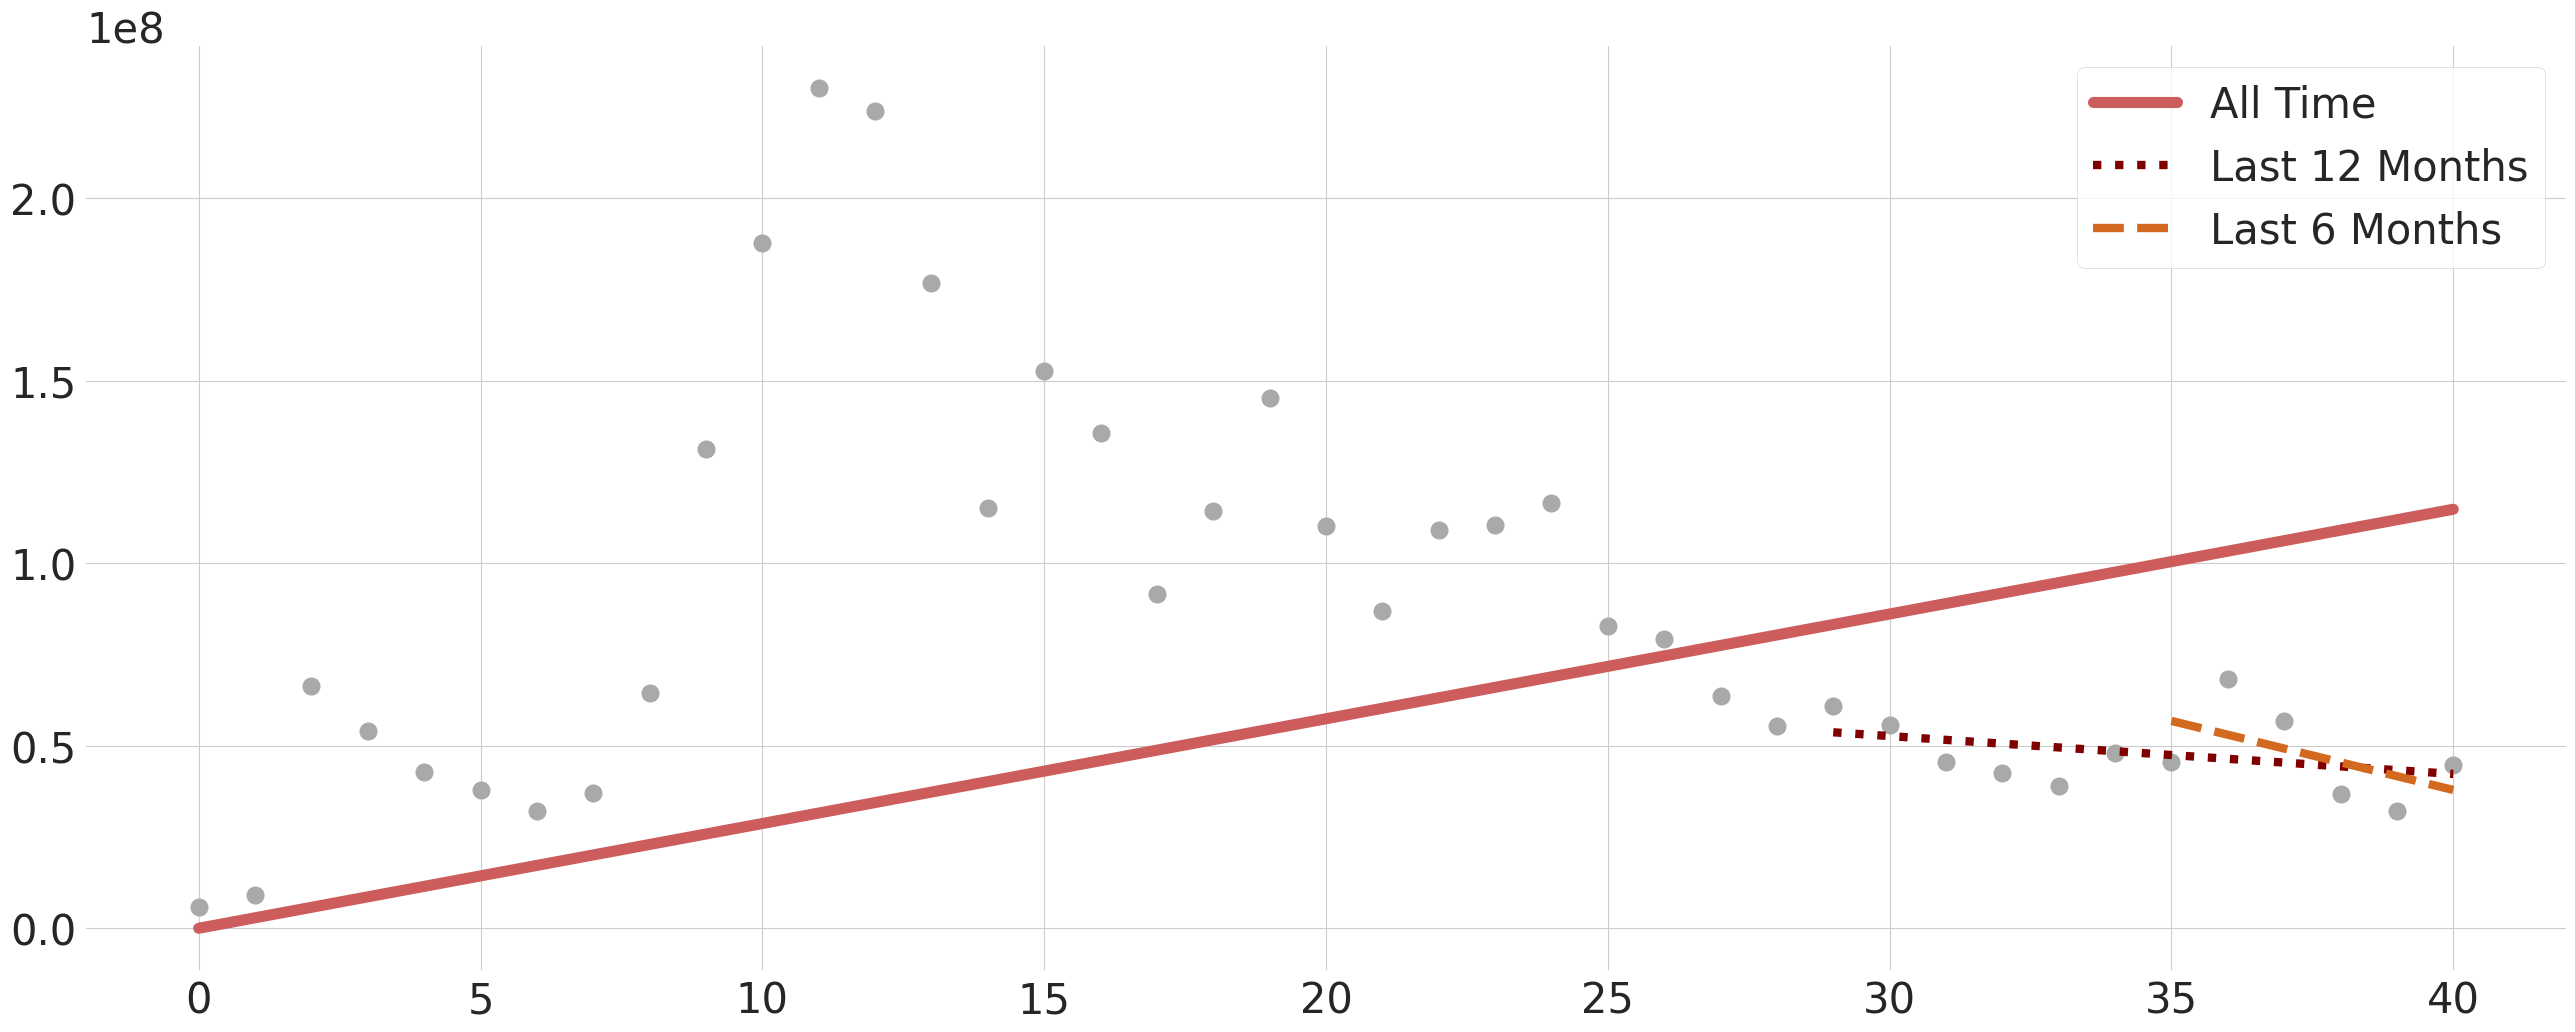

In [75]:
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(32,12))

song = popularity[popularity.id == popularity.id[213282]].sort_values(["YEAR", "MONTH"]).reset_index(drop=True).reset_index()
#Last 6 months
last6 = song.iloc[-6:, :].copy().reset_index(drop=True)
lm6 = LinearRegression()
lm6.fit(last6[["index"]], last6["TOTAL_VIEWS"])
coef6, intr6 = lm6.coef_[0], lm6.intercept_

#Last 12 months
last12 = song.iloc[-12:, :].copy().reset_index(drop=True)
lm12 = LinearRegression()
lm12.fit(last12[["index"]], last12["TOTAL_VIEWS"])
coef12, intr12 = lm12.coef_[0], lm12.intercept_

#Total trend
lm = LinearRegression(fit_intercept=False)
lm.fit(song[["index"]], song["TOTAL_VIEWS"])
coef, intr = lm.coef_[0], lm.intercept_

prdlm = intr + coef * song["index"]
prd6 = intr6 + coef6 * last6["index"]
prd12 = intr12 + coef12 * last12["index"]

plt.plot(song["index"], song["TOTAL_VIEWS"], "o", c='#A9A9A9', markersize=12)
plt.plot(song["index"], prdlm, label="All Time", c='#CD5C5C', linewidth=8)
plt.plot(last12["index"], prd12, label="Last 12 Months", linestyle=":",  c='maroon', linewidth=6)
plt.plot(last6["index"], prd6, label="Last 6 Months", linestyle="--", c='#D2691E', linewidth=6)

plt.legend()
#plt.title('Coefficients of Total Views of a Song')
plt.xlabel("");
plt.ylabel("");
sns.despine(bottom=True, left=True)
plt.show()

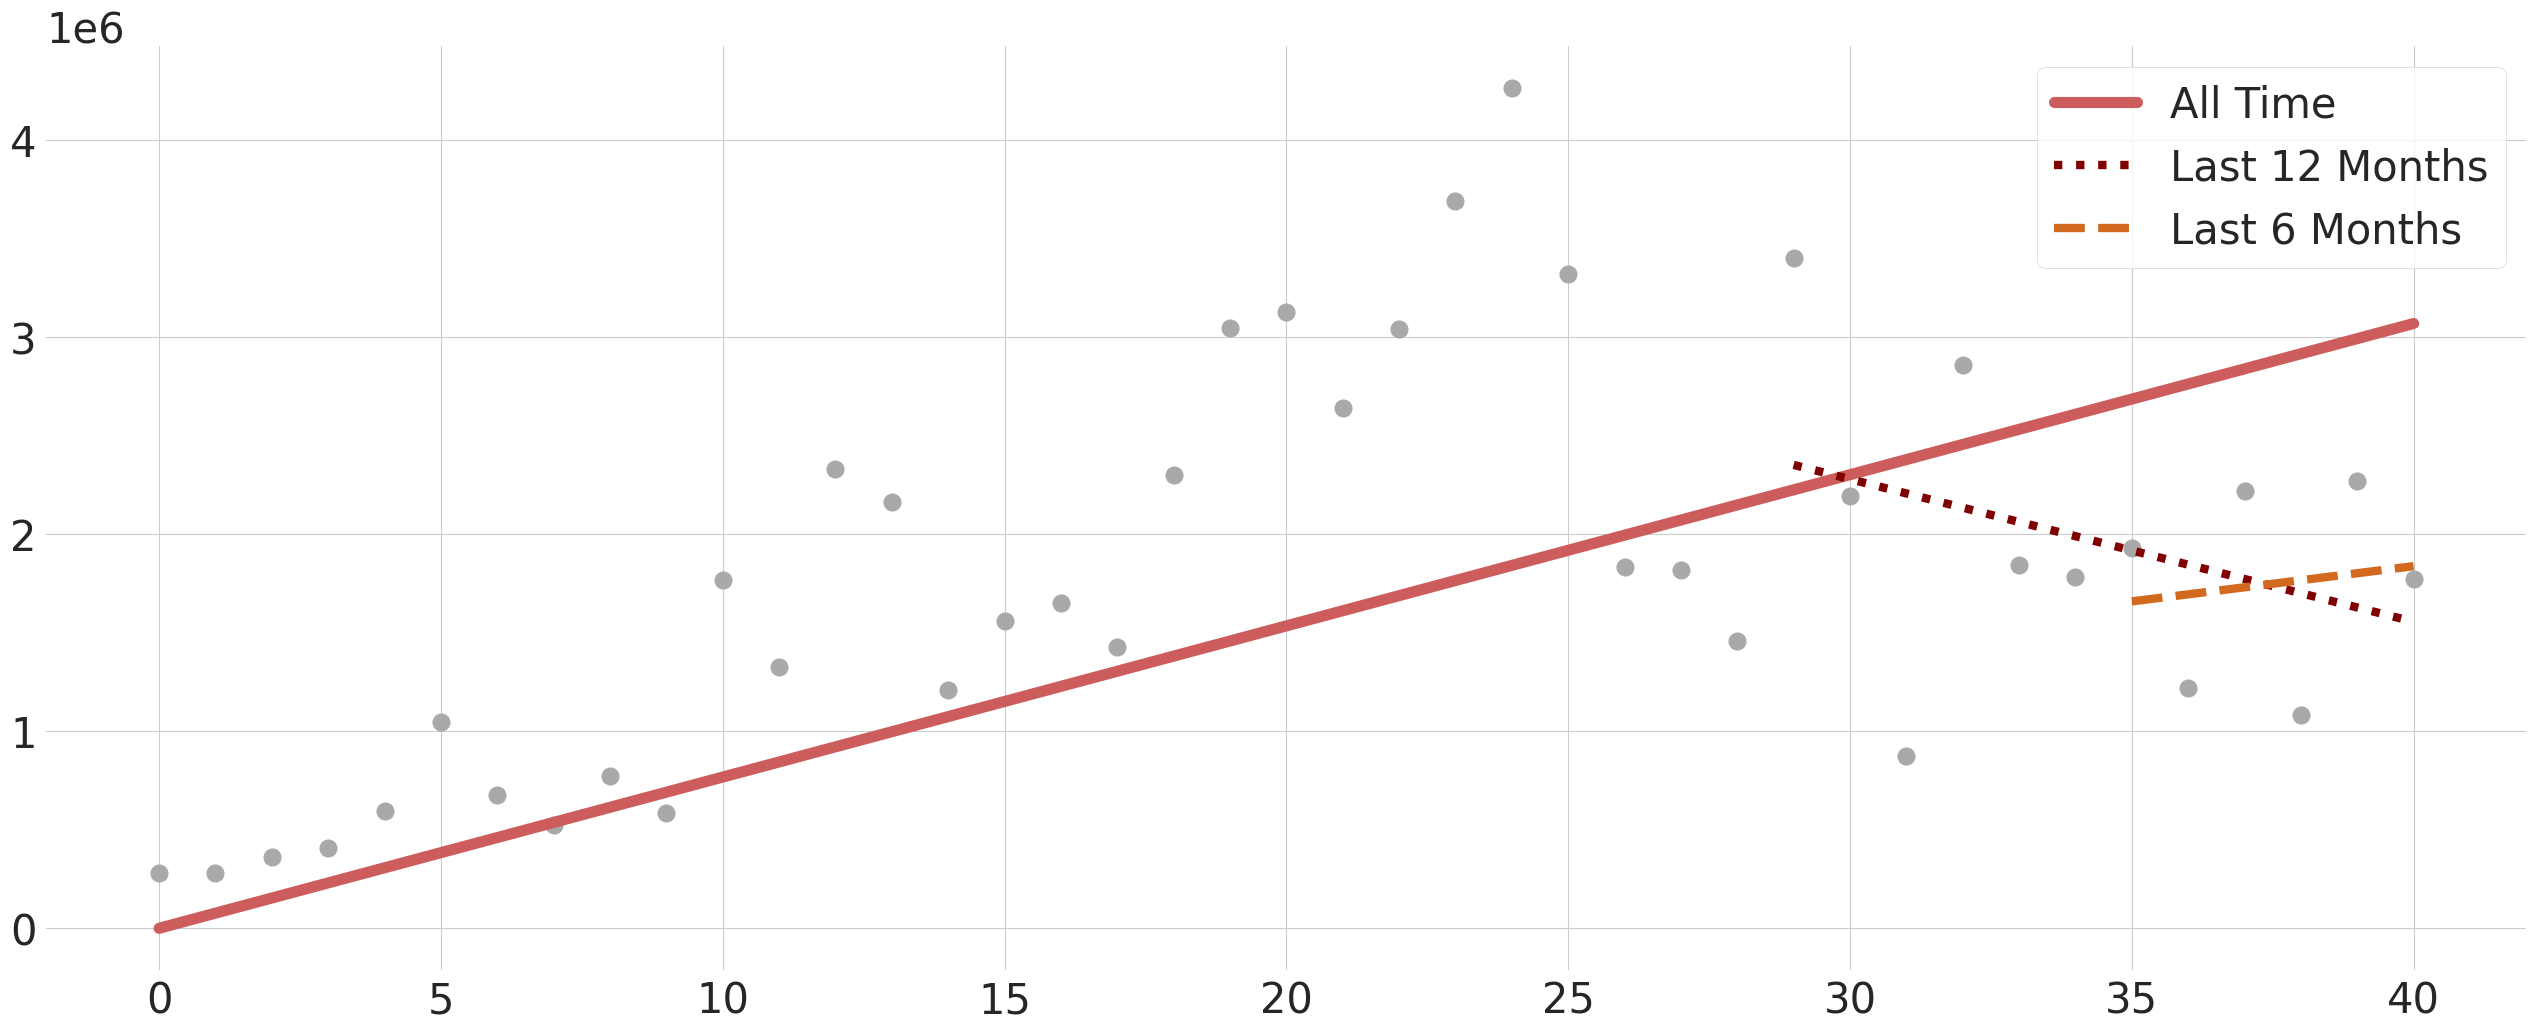

In [76]:
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(32,12))

song = popularity[popularity.id == popularity.id[213282]].sort_values(["YEAR", "MONTH"]).reset_index(drop=True).reset_index()
#Last 6 months
last6 = song.iloc[-6:, :].copy().reset_index(drop=True)
lm6 = LinearRegression()
lm6.fit(last6[["index"]], last6["PEAK_VIEWS"])
coef6, intr6 = lm6.coef_[0], lm6.intercept_

#Last 12 months
last12 = song.iloc[-12:, :].copy().reset_index(drop=True)
lm12 = LinearRegression()
lm12.fit(last12[["index"]], last12["PEAK_VIEWS"])
coef12, intr12 = lm12.coef_[0], lm12.intercept_

#Total trend
lm = LinearRegression(fit_intercept=False)
lm.fit(song[["index"]], song["PEAK_VIEWS"])
coef, intr = lm.coef_[0], lm.intercept_

prdlm = intr + coef * song["index"]
prd6 = intr6 + coef6 * last6["index"]
prd12 = intr12 + coef12 * last12["index"]

plt.plot(song["index"], song["PEAK_VIEWS"], "o", c='#A9A9A9', markersize=12)
plt.plot(song["index"], prdlm, label="All Time", c='#CD5C5C', linewidth=8)
plt.plot(last12["index"], prd12, label="Last 12 Months", linestyle=":",  c='maroon', linewidth=6)
plt.plot(last6["index"], prd6, label="Last 6 Months", linestyle="--", c='#D2691E', linewidth=6)

plt.legend()
#plt.title('Coefficients of Peak Views of a Song')
plt.xlabel("");
plt.ylabel("");
sns.despine(bottom=True, left=True)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


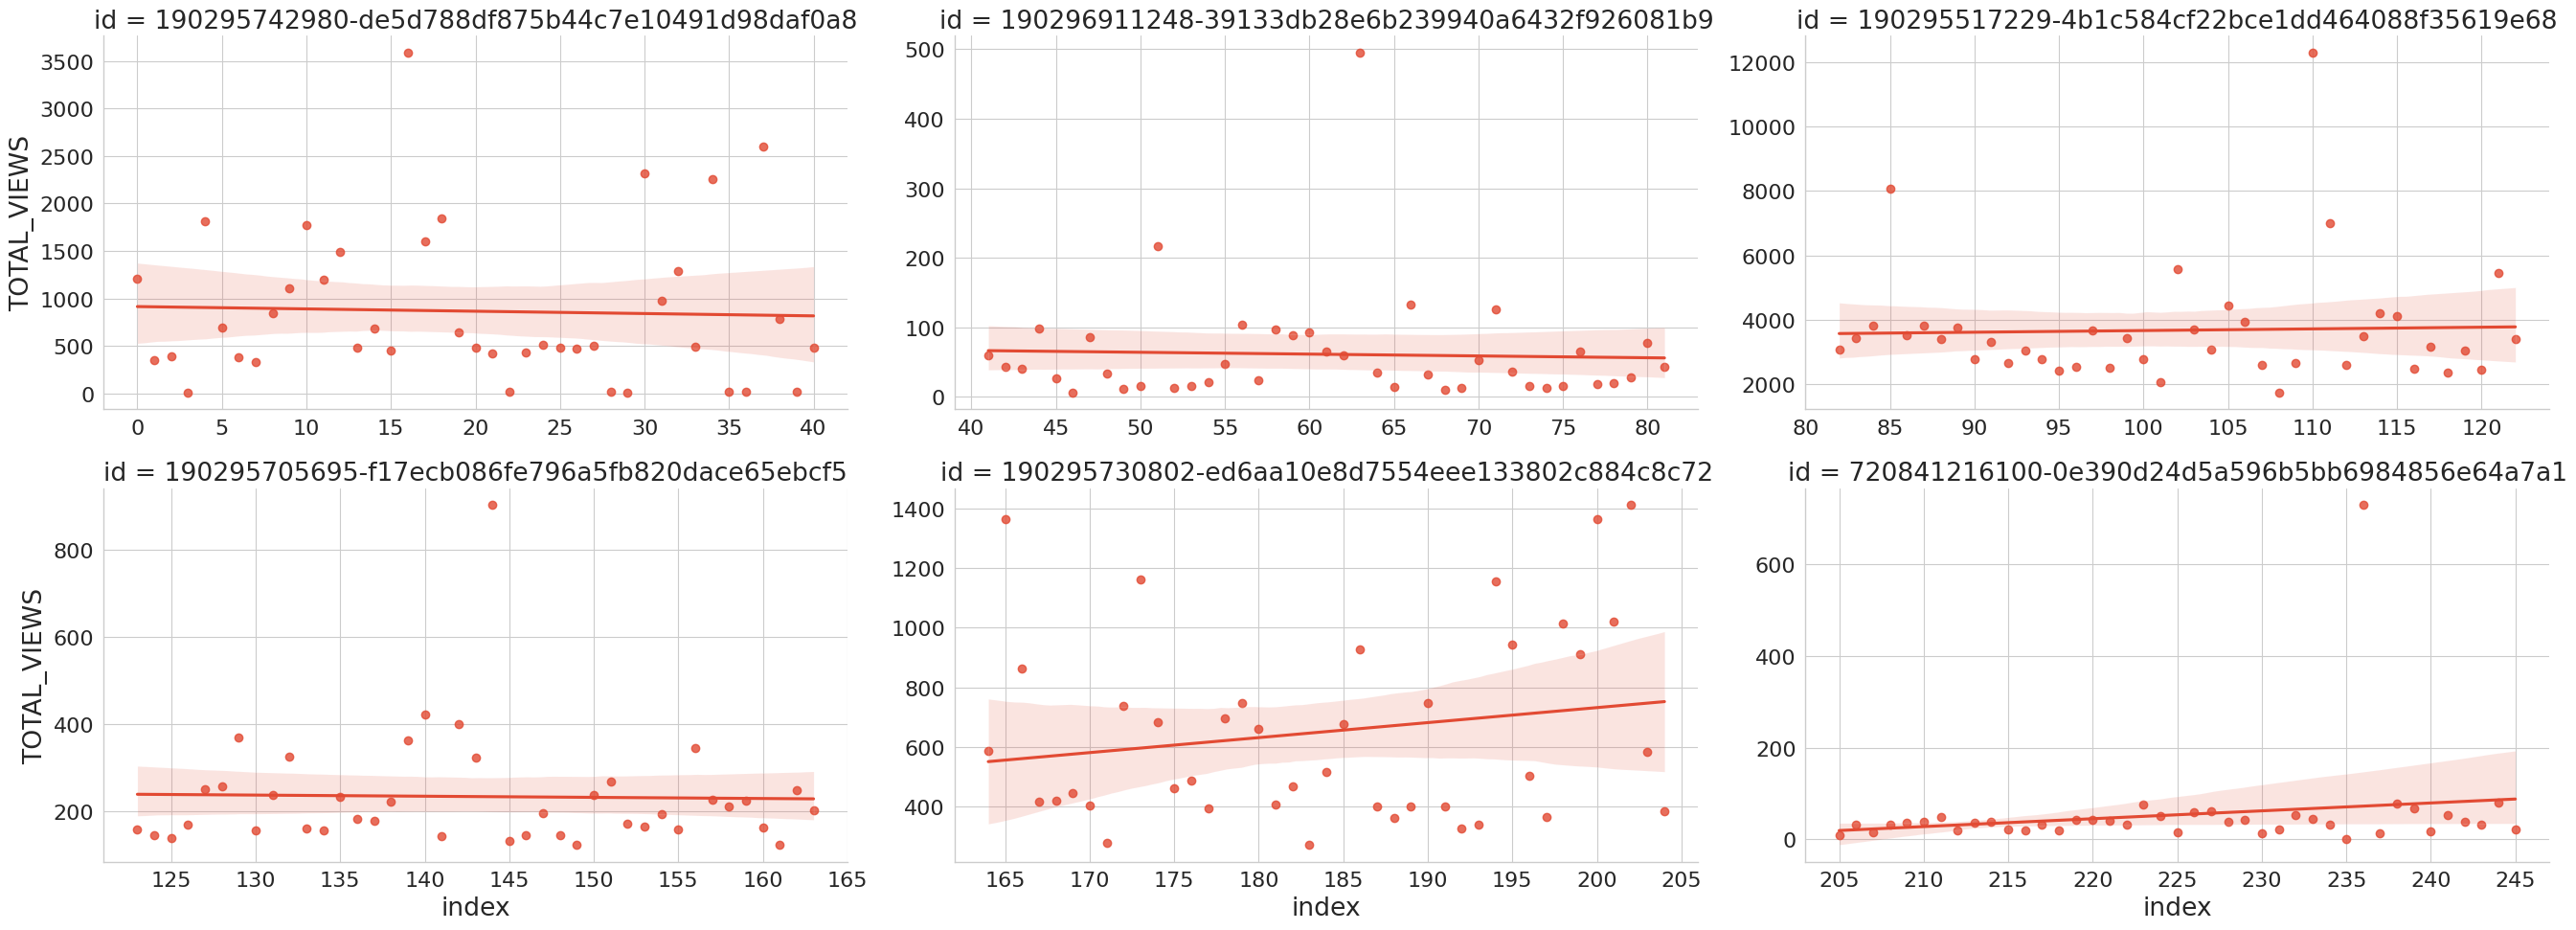

In [11]:
#Trend for first 6 songs
plot_data = popularity[:41*6].reset_index()
sns.lmplot(x='index', y='TOTAL_VIEWS', data = plot_data, col='id', col_wrap=3, sharex=False, sharey=False, height=5, aspect=1.8)
plt.tight_layout()
plt.show()

### Coefficients for 2019-2022 and May 2021-May 2022

In [12]:
#coefficients
def add_coef(df, cum_sum=False):
    
    df = df.sort_values(["YEAR", "MONTH"]).reset_index(drop=True).reset_index()
#For 2022-2019
    lm = LinearRegression(fit_intercept=False)
    tv_coef = lm.fit(df.reset_index()[["index"]], df["TOTAL_VIEWS"])
    lm = LinearRegression(fit_intercept=False)
    pv_coef = lm.fit(df.reset_index()[["index"]], df["PEAK_VIEWS"])   
#For 2022
    lm = LinearRegression()
    tv_coef_12 = lm.fit(df.iloc[-12:, :].reset_index()[["index"]], df.iloc[-12:, :]["TOTAL_VIEWS"])
    lm = LinearRegression()
    pv_coef_12 = lm.fit(df.iloc[-12:, :].reset_index()[["index"]], df.iloc[-12:, :]["PEAK_VIEWS"]) 
    return pd.DataFrame([[df["id"].values[0], tv_coef.coef_[0], pv_coef.coef_[0], tv_coef_12.coef_[0], pv_coef_12.coef_[0]]],
                          columns=["id", "TOTAL_VIEWS_coef", "PEAK_VIEWS_coef", "TOTAL_VIEWS_coef_12", "PEAK_VIEWS_coef_12"],)

In [13]:
trends = popularity.groupby("id").apply(add_coef).reset_index(drop=True)
trends.head()

id  TOTAL_VIEWS_coef  \
0  00191018727130-1E2972E03795F64C6EBAA98DF947EC0E       5323.020416   
1  00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6        351.834282   
2  00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB         44.805827   
3  00191018812614-770F9C647B13ABAEB610FB62191A1674         16.265899   
4  00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583       1420.173306   

   PEAK_VIEWS_coef  TOTAL_VIEWS_coef_12  PEAK_VIEWS_coef_12  
0       139.770416        -34079.923077         -632.164336  
1        43.429630         -3423.160839          -75.772727  
2        22.968880            86.636364           73.013986  
3         2.589973            -7.979021            3.790210  
4       131.655059          2722.797203           68.643357

## Mel Spectrograms

**Mel spectrograms** are a well-known tool to represent audio data in a visual format. The Mel Scale is a logarithmic transformation of a signal’s frequency. The core idea of this transformation is that sounds of equal distance on the Mel Scale are perceived to be of equal distance to humans. In this way, patterns regarding beat, timbre, etc. can be detected by a model. In this project, we are given **Mel-Spectrograms** in the form of numpy arrays (a matrix).  

These **Mel-Spectrograms** can be visualized with a heatmap; the x axis is the time, and the y axis are the frequencies. These spectrograms have been power (log) scaled (amplitude squared) and converted to decibel (dB) units.

In [10]:
#Reading Mel-Spectrograms and adding them to a dictionairy
filenames = []   
spectrograms = {} #filaneme:Mel-Spectrogram dict

for file in os.listdir(os.getcwd() + '/mfccs'):
    file = file.split('.')[0]
    filenames.append(file)
    path = os.path.join(os.getcwd() + '/mfccs', file + '.npy')
    spectrograms[file] = np.load(path)
    
print(f"We have {len(set(filenames))} total Mel-Spectrograms. Each one has dimensions {spectrograms[filenames[91]].shape[0]} (frequencies) x {spectrograms[filenames[91]].shape[1]} (time frames).")

We have 11282 total Mel-Spectrograms. Each one has dimensions 128 (frequencies) x 1292 (time frames).


### Visualization of the Mel-Spectrogram of one song

In [12]:
filenames.index('190296919015-6a75ff6818c16f56455540d3d8f849b7')

6507

In [5]:
song = pd.DataFrame(spectrograms[filenames[6507]]) #For one song, in dB 6507
song

0          1          2          3          4          5     \
0   -67.996758 -26.569330 -13.160105  -6.139133 -20.783840  -3.529258   
1   -70.013504 -18.905203  -5.711262  -1.308020   5.202134  -3.380191   
2   -86.951553 -15.063007  -1.895543   2.027932   9.528113  -3.057163   
3   -67.942261  -7.715287   8.472640   9.295547  17.906788  21.049231   
4   -63.620438  -2.728769   4.390759  16.290533  16.848475  23.136181   
5   -64.876266   2.489403  11.050716  17.217813  13.564577  20.140369   
6   -67.936096   6.225029  15.985879  16.654808  10.946465  12.189957   
7   -76.326584   9.153432  19.034475  13.054422  15.005638   2.010486   
8   -65.395554  11.612257  15.241117  15.807733  14.417776   8.933962   
9   -63.849110  12.497169  10.969471  15.941765  16.498909  16.056997   
10  -61.683117  13.695846  12.026481  13.332909  15.434053  17.743763   
11  -67.657822  15.799238  18.564354  16.327354  17.889383  19.285217   
12  -60.416965  17.016886  23.261528  21.368416  23.189545  23.667776   
13  -52.887398  16.777296  21.566547  18.691015  20.711086  21.244320   
14  -50.651134  15.067364  15.097399   9.118293  11.377245  13.506887   
15  -49.973259  12.496321   9.525841  12.053918  11.798393  15.417135   
16  -52.126461   9.589651  10.219887  13.425149  13.666254  15.423203   
17  -58.247253   7.557518   5.953753   9.518829  10.553827   9.440031   
18  -51.273750  14.229183  18.702169  14.318359  14.943744  14.928142   
19  -45.239914  18.334864  26.746174  24.047466  23.440170  23.870998   
20  -42.573311  18.621252  25.679535  22.227890  21.954271  22.438963   
21  -43.080238  17.544624  18.370392  16.420515  18.016598  17.576292   
22  -46.970428  18.357687  24.084419  23.631332  24.969723  24.845852   
23  -54.236378  15.688094  23.496210  22.899790  23.665792  23.500843   
24  -48.105064   8.501243  13.331495  11.326610  11.122323  10.453007   
25  -43.598629  12.945322   3.969834   1.627760   1.607002   1.487932   
26  -43.917789  17.345472  17.908686  16.172138  16.755545  16.963652   
27  -49.633217  18.012283  22.069210  19.801716  19.728802  20.661829   
28  -53.777817  15.508913  17.808006  14.724691  13.618175  16.059595   
29  -47.096859  12.239428   8.063325   5.511641   6.782572   7.770855   
30  -47.169823   7.410973   7.672059   2.728166   6.679273   5.785437   
31  -52.193169   7.930684   8.639991   6.328948   6.298103   8.599789   
32  -49.612495  11.602139  15.521222  12.582464  11.954230   9.696110   
33  -44.500137   8.880533  19.817991  20.737099  22.915344  22.255657   
34  -45.114929  -2.927941  13.950590  15.939119  19.765127  19.136963   
35  -50.978798  -2.865261  -1.513226  -5.072876   3.236242  -2.290434   
36  -53.866463   5.734438   3.871459  -3.609461  -5.247369  -5.528658   
37  -49.241032  11.228449   8.780782   9.031937   9.413815  10.250975   
38  -52.546078  14.508780  16.021765  16.010143  16.638103  16.445133   
39  -62.753975  15.470484  20.315910  20.026463  20.581758  20.158810   
40  -64.756966  11.526867  15.355192  14.703739  15.171009  14.830061   
41  -53.209324   6.673965   5.828781   6.727973   5.941269   5.218677   
42  -48.601685   5.041609  13.280985  12.598037  12.486339  12.511791   
43  -50.554817   2.064835   7.870085   6.418762   5.740237   5.821580   
44  -53.834724   2.045183  -2.186812   2.930793  -1.116833   1.477379   
45  -47.621803   2.233412  -0.587292   0.287419  -2.846622  -1.735287   
46  -49.091679  -1.017696   2.126679  -0.205200  -3.453318  -2.123045   
47  -56.269936  -9.298512  -4.709828  -7.712945 -12.700858  -8.539075   
48  -53.373814  -2.347717   3.393505   3.209264   0.017240   1.545417   
49  -56.631668   4.225691  10.404945   9.227489   3.899014   6.448322   
50  -51.793385   2.661393   5.936031   4.213229  -1.897307  -0.905720   
51  -53.769318  -0.320111  -9.069308  -7.233496 -11.048948  -9.631954   
52  -52.137455  -1.862433   3.386165   4.694483   9.308661   9.078440   
53  -49.740173   0.494716   8.488460   7.803888  12.706882  13.16181

In [6]:
pd.DataFrame(librosa.feature.mfcc(S=song.values, n_mfcc=13))

0           1           2           3           4           5     \
0  -664.670898 -122.589088  -88.172188 -103.413147  -92.789505  -82.958366   
1    28.240749  183.214569  187.113617  189.319885  180.163849  174.383667   
2    -8.627554   -8.960446   12.256408   34.501942   41.316200   39.497078   
3   -41.535568  -43.545856  -49.307518  -56.232910  -50.347996  -47.661182   
4   -35.742851   -6.569511    2.990888    6.213533   -2.307481   -3.858714   
5   -11.678669  -40.961239  -27.687737  -12.297002  -12.430410   -7.279010   
6   -20.222496  -22.188019  -16.421238  -15.324615  -16.160458  -20.894722   
7   -25.399178   -0.141855    1.790618    8.512416    6.655428    5.549995   
8     0.625319  -35.382568  -26.581833  -23.995495  -19.607952  -16.234882   
9     0.185121   -9.083841    2.544637   -4.427368   -1.854428   -8.678541   
10   -6.346851  -19.318130  -18.078012   -8.732364  -11.497944   -6.551798   
11   11.700123   -1.664920   -1.652182    1.067929   -1.906224    0.184489   
12   -4.352634  -10.632063   -1.988257   -2.015115  -10.231212   -6.806304   

          6           7           8           9     ...       1282       1283  \
0   -76.234596  -74.163986  -67.738945  -64.151077  ...  10.997097  40.797226   
1   170.976685  175.352951  161.227356  154.140701  ...  92.939606  69.006195   
2    42.021065   38.497040   47.385754   49.905724  ...  48.391853  55.696312   
3   -39.851089  -36.203533  -26.370148  -26.535774  ...  35.562824  24.979519   
4    -7.085544    2.942347   -4.931675   -9.936029  ...  20.670582   9.877737   
5    -5.840624   -8.180034   -7.590681   -0.510127  ...  -3.446707   6.939820   
6   -14.909785  -20.863342  -16.009787  -11.226568  ...  20.325548  16.824183   
7    -0.320145    5.263409    4.157237   -3.622021  ...  -0.111879   9.042779   
8   -19.366432  -12.032510  -14.337884  -17.072565  ...  -0.652879  -3.556700   
9    -5.109667   -9.087731  -11.506970   -8.382928  ...   1.920333   4.223041   
10   -9.316410  -15.372303  -11.423622   -8.169567  ...   2.543608 -10.166926   
11    0.877392    1.720405    2.125203   -3.100482  ...  -7.492480  -7.413278   
12   -8.762880   -0.207169   -1.409253   -1.834755  ...   6.910337   0.637057   

         1284       1285        1286        1287       1288       1289  \
0   47.957123  14.323713    4.746792   -7.114587  23.585667  35.453037   
1   81.332283  98.982452  117.225777  109.019951  83.562393  90.890259   
2   32.963825  30.514603   29.128300   38.413795  49.503494  36.400154   
3   25.582161  35.729141   48.656204   51.123512  36.473015  38.372375   
4   12.316481   1.607016   11.410696   21.184555   6.533452   6.723285   
5   17.305271  12.388426    2.461186    0.663352  13.939049  15.672828   
6   19.513140  27.598429   24.747570   23.473318  16.531960  19.828671   
7   10.601237   8.998716    0.237250   -4.969911  11.117244   6.379585   
8   -1.558469   3.096749   -4.030019   -6.974285  -4.354095  -3.084432   
9   -3.725549   1.050964    0.886797    0.407937  -1.309901  -6.461637   
10 -11.381605  -4.818523   -8.172739   -2.679749  -9.912277 -15.960170   
11   1.389180   0.546298   -2.392524   -2.295420  -4.149432  -0.219699   
12  -6.333125  -8.682711   -6.414813   -1.677375   1.068925   3.488987   

         1290        1291  
0    9.941339   -6.156240  
1   96.270187  104.928642  
2   35.690662   32.498383  
3   46.931908   53.220787  
4   14.450195   19.981094  
5    9.035962   10.340727  
6   22.049835   27.794449  
7    5.289285    1.437227  
8    2.353167   -4.682529  
9   -4.890910   -2.107906  
10 -14.008078   -7.099565  
11   1.161696    1.074098  
12   4.139032    0.471552  

[13 rows x 1292 columns]

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(22,6))

img = librosa.display.specshow(song.values, y_axis='mel', x_axis='time', cmap='magma', ax=ax)
#ax.set(title='Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(22,6))

img = librosa.display.specshow(song.values, y_axis='mel', x_axis='time', cmap='magma', ax=ax)
#ax.set(title='Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

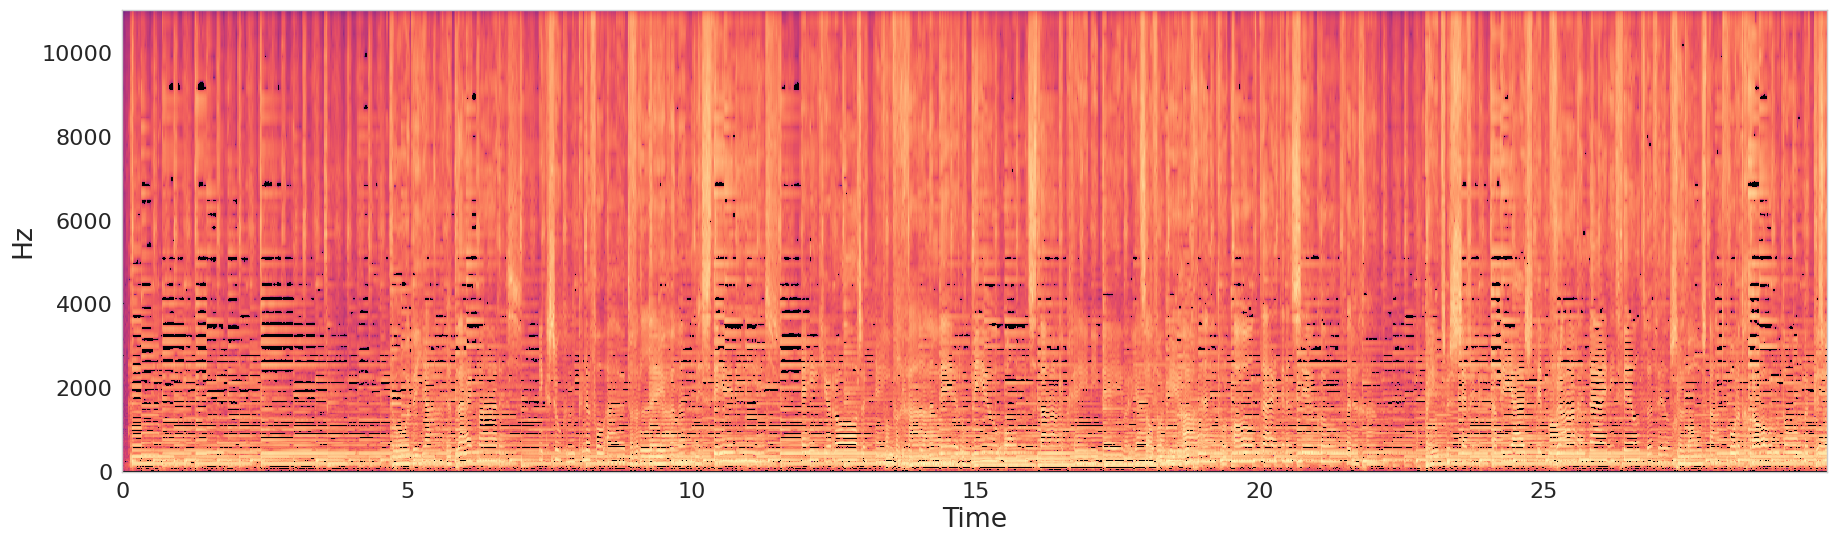

In [18]:
#Reverse to Spectrogram
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(22,6))
S = librosa.feature.inverse.mel_to_stft(librosa.db_to_amplitude(song.values))
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='linear', x_axis='time', cmap='magma', ax=ax)

#fig.colorbar(img, ax=ax, format="%+2.0f dB")

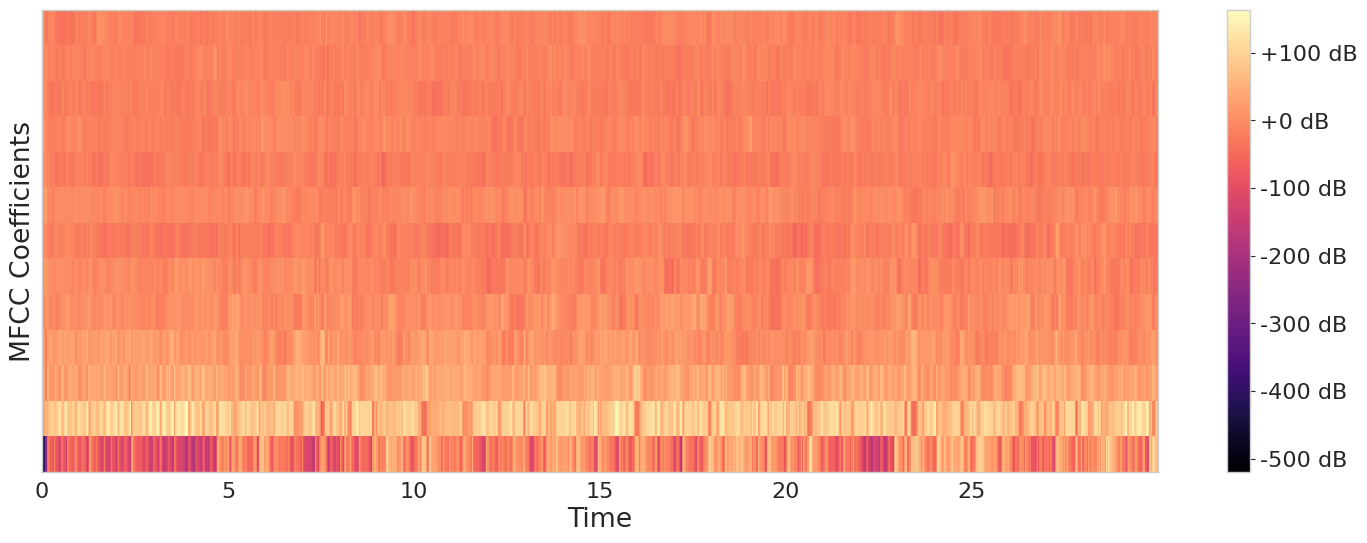

In [19]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
#scaled
img = librosa.display.specshow(librosa.feature.mfcc(S=song.values, n_mfcc=13).astype(float), x_axis='time', cmap='magma', ax=ax)
ax.set_ylabel('MFCC Coefficients')
fig.colorbar(img, ax=ax, format="%+2.f dB")

### Creating the dataset of Mel-Spectrograms

In [13]:
all_spectrograms = pd.DataFrame(spectrograms.items(), columns = ['id', 'mel_spectrogram']).set_index('id')
all_spectrograms.head()

mel_spectrogram
id                                                                                                
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E  [[-27.361317, -11.880363, -2.2760637, 0.452192...
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6  [[11.305796, 8.42963, 7.4199257, 5.9783335, 27...
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB  [[-85.15028, -75.606544, -84.16371, -81.77144,...
00191018812614-770F9C647B13ABAEB610FB62191A1674  [[-34.347233, -11.759057, 18.057917, 16.440456...
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583  [[7.988597, 12.766906, 9.339082, 11.907147, 1....

In [ ]:
#MFCC's
#https://musicinformationretrieval.com/mfcc.html
#https://hackernoon.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analyis-wt6p32qz
mfccs = {k:librosa.feature.mfcc(S=v, n_mfcc=13) for k, v in spectrograms.items()}

mfccs = pd.DataFrame(mfccs.items(), columns = ['id', 'mfccs'])
mfccs = pd.DataFrame([np.mean(x.T,axis=0) for x in mfccs.mfccs], index = mfccs.id)
mfccs.rename(columns=lambda x: 'coef_' + str(x), inplace = True)
mfccs.head()

In [72]:
#Delta
delta_1 = {k:librosa.feature.mfcc(S=v, n_mfcc=13) for k, v in spectrograms.items()}
delta_1 = {k:librosa.feature.delta(data=v, order=1) for k, v in delta_1.items()}

delta_1 = pd.DataFrame(delta_1.items(), columns = ['id', 'delta_1'])
delta_1 = pd.DataFrame([np.mean(x.T,axis=0) for x in delta_1.delta_1], index = delta_1.id)
delta_1.rename(columns=lambda x: 'delta1_' + str(x), inplace = True)
delta_1.head()

delta1_0  delta1_1  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.817393  0.105538   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.892461  0.118638   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       1.104031  0.084765   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.415134  0.101675   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.700740 -0.062154   

                                                    delta1_2  delta1_3  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.023162  0.012039   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.021593  0.042529   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       0.063212  0.011648   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.000860 -0.020436   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.005504  0.078274   

                                                    delta1_4  delta1_5  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.002523  0.003246   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.012006  0.025013   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.016934  0.010723   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.002164 -0.000649   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.013500  0.009990   

                                                    delta1_6  delta1_7  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.003489  0.003708   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.013958 -0.004730   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       0.003359  0.005501   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.007640  0.003675   
840588109678-8c329eb37671da5ce764bb13fa18735d      -0.013030 -0.010764   

                                                    delta1_8  delta1_9  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.010386  0.005049   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.022126 -0.009013   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       0.006801  0.000862   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.010121  0.009792   
840588109678-8c329eb37671da5ce764bb13fa18735d      -0.020736 -0.020948   

                                                    delta1_10  delta1_11  \
id                                                                         
190295558062-55c0db15b0882771a904ad0a3a75918c       -0.001830  -0.000957   
190295501433-5d798340ae6e115eb66cc45220512bc6       -0.010810  -0.003684   
190295568689-9492cef9a688aba3ade92e6ccfe089ec        0.025884   0.018498   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...   0.002181  -0.012329   
840588109678-8c329eb37671da5ce764bb13fa18735d       -0.024421  -0.019006   

                                                    delta1_12  
id                                                             
190295558062-55c0db15b0882771a904ad0a3a75918c        0.005249  
190295501433-5d798340ae6e115eb66cc45220512bc6       -0.011233  
190295568689-9492cef9a688aba3ade92e6ccfe089ec        0.001358  
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  -0.010609  
840588109678-8c329eb37671da5ce764bb13fa18735d        0.010811

In [73]:
#Delta_Delta
delta_2 = {k:librosa.feature.mfcc(S=v, n_mfcc=13) for k, v in spectrograms.items()}
delta_2 = {k:librosa.feature.delta(data=v, order=2) for k, v in delta_2.items()}

delta_2 = pd.DataFrame(delta_2.items(), columns = ['id', 'delta_2'])
delta_2 = pd.DataFrame([np.mean(x.T,axis=0) for x in delta_2.delta_2], index = delta_2.id) #mean for every song
delta_2.rename(columns=lambda x: 'delta2_' + str(x), inplace = True)
delta_2.head()

delta2_0  delta2_1  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.002777 -0.002286   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.194231 -0.038774   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       0.070208  0.006759   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.019842  0.029928   
840588109678-8c329eb37671da5ce764bb13fa18735d      -0.042560 -0.006494   

                                                    delta2_2  delta2_3  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.005505  0.001028   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.012518 -0.011031   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       0.015105 -0.007769   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.015724  0.006020   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.002741  0.009916   

                                                    delta2_4  delta2_5  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.002436  0.006455   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.000089 -0.006800   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.011760 -0.004681   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.004469 -0.003018   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.010129 -0.002969   

                                                    delta2_6  delta2_7  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.005927  0.002157   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.005449  0.007351   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.011614 -0.019374   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.001044  0.001508   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.000239 -0.002173   

                                                    delta2_8  delta2_9  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c      -0.003292  0.000646   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.010460 -0.002794   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.008487 -0.006115   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.000404 -0.002383   
840588109678-8c329eb37671da5ce764bb13fa18735d      -0.003167 -0.008882   

                                                    delta2_10  delta2_11  \
id                                                                         
190295558062-55c0db15b0882771a904ad0a3a75918c        0.002689   0.001945   
190295501433-5d798340ae6e115eb66cc45220512bc6        0.000014  -0.002549   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       -0.004029  -0.006461   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  -0.005156  -0.002587   
840588109678-8c329eb37671da5ce764bb13fa18735d       -0.012890  -0.004863   

                                                    delta2_12  
id                                                             
190295558062-55c0db15b0882771a904ad0a3a75918c       -0.000805  
190295501433-5d798340ae6e115eb66cc45220512bc6       -0.001317  
190295568689-9492cef9a688aba3ade92e6ccfe089ec       -0.006697  
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...   0.001662  
840588109678-8c329eb37671da5ce764bb13fa18735d       -0.000594

In [74]:
mfccs = mfccs.merge(delta_1,on='id').merge(delta_2,on='id')
mfccs.head()

coef_0      coef_1  \
id                                                                           
190295558062-55c0db15b0882771a904ad0a3a75918c       121.146538   32.566837   
190295501433-5d798340ae6e115eb66cc45220512bc6        -8.781240  103.247505   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -195.141617   89.749039   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -159.874619  129.134872   
840588109678-8c329eb37671da5ce764bb13fa18735d        24.609550   87.649902   

                                                       coef_2     coef_3  \
id                                                                         
190295558062-55c0db15b0882771a904ad0a3a75918c        1.039878  -0.971264   
190295501433-5d798340ae6e115eb66cc45220512bc6       15.845793  22.685934   
190295568689-9492cef9a688aba3ade92e6ccfe089ec       40.476192  -0.887868   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...   6.536043  -5.557824   
840588109678-8c329eb37671da5ce764bb13fa18735d      -62.396667  15.820679   

                                                       coef_4     coef_5  \
id                                                                         
190295558062-55c0db15b0882771a904ad0a3a75918c       -3.598313   0.960475   
190295501433-5d798340ae6e115eb66cc45220512bc6        8.712263   0.864660   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -28.924562 -32.666634   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -11.921021 -13.890158   
840588109678-8c329eb37671da5ce764bb13fa18735d       -7.036009  13.279514   

                                                       coef_6     coef_7  \
id                                                                         
190295558062-55c0db15b0882771a904ad0a3a75918c       -4.744246  -3.282699   
190295501433-5d798340ae6e115eb66cc45220512bc6       -5.544940 -10.301381   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -37.392963 -29.659336   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -19.993736  -5.058798   
840588109678-8c329eb37671da5ce764bb13fa18735d        2.920045   3.874733   

                                                       coef_8     coef_9  ...  \
id                                                                        ...   
190295558062-55c0db15b0882771a904ad0a3a75918c       -6.802675   0.918456  ...   
190295501433-5d798340ae6e115eb66cc45220512bc6       -6.918319   0.124162  ...   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -26.314650 -11.224069  ...   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  -5.162035  -0.828014  ...   
840588109678-8c329eb37671da5ce764bb13fa18735d        0.065035   0.299135  ...   

                                                    delta2_3  delta2_4  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.001028  0.002436   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.011031 -0.000089   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.007769 -0.011760   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e...  0.006020 -0.004469   
840588109678-8c329eb37671da5ce764bb13fa18735d       0.009916  0.010129   

                                                    delta2_5  delta2_6  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.006455  0.005927   
190295501433-5d798340ae6e115eb66cc45220512bc6      -0.006800  0.005449   
190295568689-9492cef9a688aba3ade92e6ccfe089ec      -0.004681 -0.011614   
A10301A0003959585F-6e3ecfb2a1a1e2c689c5afbbad5e... -0.003018 -0.001044   
840588109678-8c329eb37671da5ce764bb13fa18735d      -0.002969  0.000239   

                                                    delta2_7  delta2_8  \
id                                                                       
190295558062-55c0db15b0882771a904ad0a3a75918c       0.002157 -0.003292   
190295501433-5d798340ae6e115eb66cc45220512bc6       0.007351  0.010460   
19029556

## Spotify tags (used as metadata)

According to Spotify, “popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.”

In [36]:
audio = pd.read_csv('audio_features.csv')
print(f"There are {audio.shape[0]} total songs in this dataframe, with {audio.shape[1]-1} spotify tags each. These are:\n{list(audio.columns[1:])}")
audio.head()

There are 10753 total songs in this dataframe, with 15 spotify tags each. These are:
['album_release_date', 'explicit', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


id album_release_date  \
0  5099968897956-2b124a15f84c72082d3be0edc700581f         1982-09-01   
1  5099969442650-830f805871294e35175f02edb2290039         2020-09-18   
2  5099969959158-fe7b5d4b06d14922b6b5f37e6e6c8176         2017-05-26   
3  5099969959257-4fb47a75c5875fb0889f83f80476b10f         2017-05-26   
4  5099969959356-ab2448efac7737b44ecdf9724bc6753a         2017-05-26   

   explicit  popularity  acousticness  danceability  energy  instrumentalness  \
0     False         2.0       0.11600         0.502   0.501          0.010100   
1     False        12.0       0.30800         0.308   0.826          0.000001   
2     False        23.0       0.00587         0.810   0.883          0.610000   
3     False        31.0       0.07790         0.749   0.655          0.276000   
4     False        22.0       0.00665         0.804   0.628          0.777000   

    key  liveness  loudness  mode  speechiness    tempo  time_signature  \
0   8.0     0.337   -10.098   1.0       0.0285   95.814             4.0   
1   4.0     0.298    -9.108   1.0       0.0535  173.547             4.0   
2  11.0     0.668    -9.468   1.0       0.0534  113.035             4.0   
3  10.0     0.116   -10.965   0.0       0.0490  121.850             4.0   
4   2.0     0.121   -13.150   1.0       0.0702  126.039             4.0   

   valence  
0    0.192  
1    0.824  
2    0.873  
3    0.679  
4    0.963

In [37]:
#album release date is different than release date - which do i keep?
audio[audio.id=='190295742980-de5d788df875b44c7e10491d98daf0a8'].album_release_date, popularity[popularity.id=='190295742980-de5d788df875b44c7e10491d98daf0a8'].iloc[1].release_date

(6706    2017-09-29
 Name: album_release_date, dtype: object,
 '2017-05-08')

/tmp/ipykernel_5150/1207925003.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = audio.corr()


<Figure size 2800x2600 with 0 Axes>

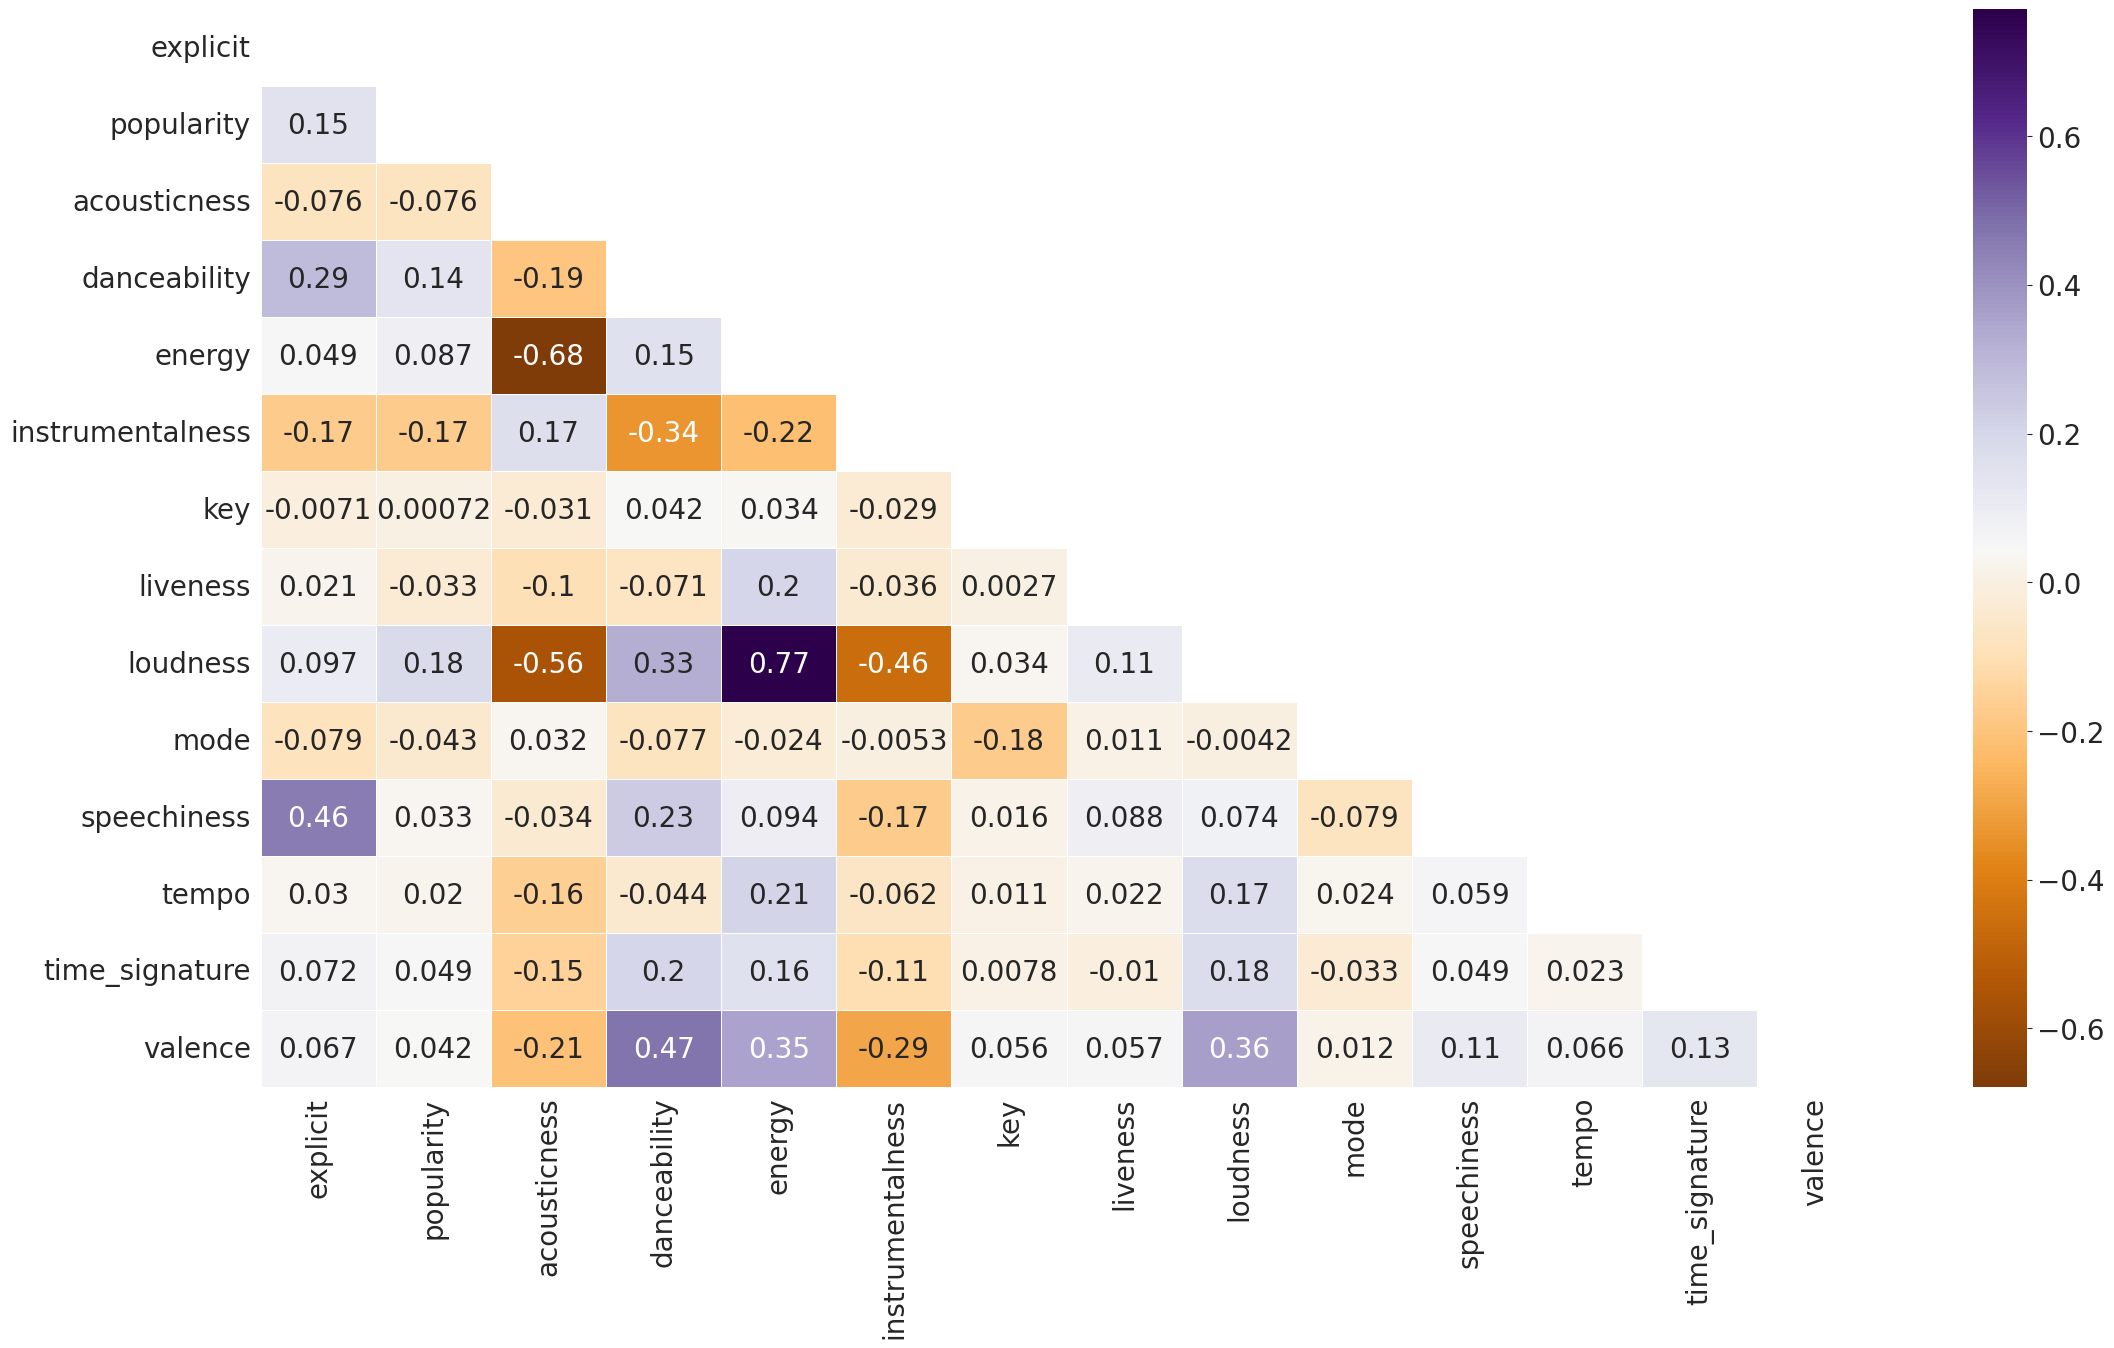

In [38]:
plt.figure(figsize=(28,26))
plt.rcParams.update({'font.size': 20})
corr = audio.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(26, 14))
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap='PuOr', linewidths=.5)

In [39]:
audio['album_release_date'] = pd.to_datetime(audio.album_release_date)
audio['year'] = audio['album_release_date'].dt.year
audio['month'] = audio['album_release_date'].dt.month
#use album_release_date as a new feature - how old the song is ????? does not standardize well.
#audio['age'] = datetime.now().year - audio['year']
audio.sort_values(by="album_release_date", inplace=True)
audio.drop('album_release_date', axis=1, inplace=True)
audio.dropna(inplace=True)

audio = pd.get_dummies(audio, columns=['time_signature', 'key'], drop_first=True)
audio['explicit'] = audio['explicit'].map(lambda x: 1 if x == True else 0)
audio.dropna(inplace=True)
print(list(audio.columns))

audio.head()

['id', 'explicit', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year', 'month', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0']


id  explicit  popularity  \
3933  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a         0         0.0   
3932  085365582460-7d18bb6e975bb08194f64ba32d633594         0         0.0   
6655  190295735838-808469824b1046469c2bb17daa75c24f         0        10.0   
5659  190295621070-0f9cda3c487da0663e3487605864e403         0         4.0   
95    603497934584-83b1b565f84bd2420d55d24acb92dc82         0         2.0   

      acousticness  danceability  energy  instrumentalness  liveness  \
3933         0.740         0.266   0.269          0.000644     0.196   
3932         0.718         0.455   0.703          0.000000     0.548   
6655         0.842         0.567   0.593          0.000013     0.618   
5659         0.637         0.193   0.141          0.802000     0.146   
95           0.763         0.629   0.802          0.000000     0.905   

      loudness  mode  ...  key_2.0  key_3.0  key_4.0  key_5.0  key_6.0  \
3933    -9.744   0.0  ...        0        0        0        0        0   
3932    -5.981   1.0  ...        0        0        0        0        0   
6655   -11.990   0.0  ...        1        0        0        0        0   
5659   -15.835   1.0  ...        1        0        0        0        0   
95      -9.546   1.0  ...        0        0        0        0        0   

      key_7.0  key_8.0  key_9.0  key_10.0  key_11.0  
3933        1        0        0         0         0  
3932        1        0        0         0         0  
6655        0        0        0         0         0  
5659        0        0        0         0         0  
95          0        0        0         1         0  

[5 rows x 30 columns]

### EDA 

As we can see from the plot below, the popularity score is a number in the range 0-80, where 80 is the score indicating the most popular song. Most of the songs on this dataset have a popularity score less than 40, deeming them as less popular.


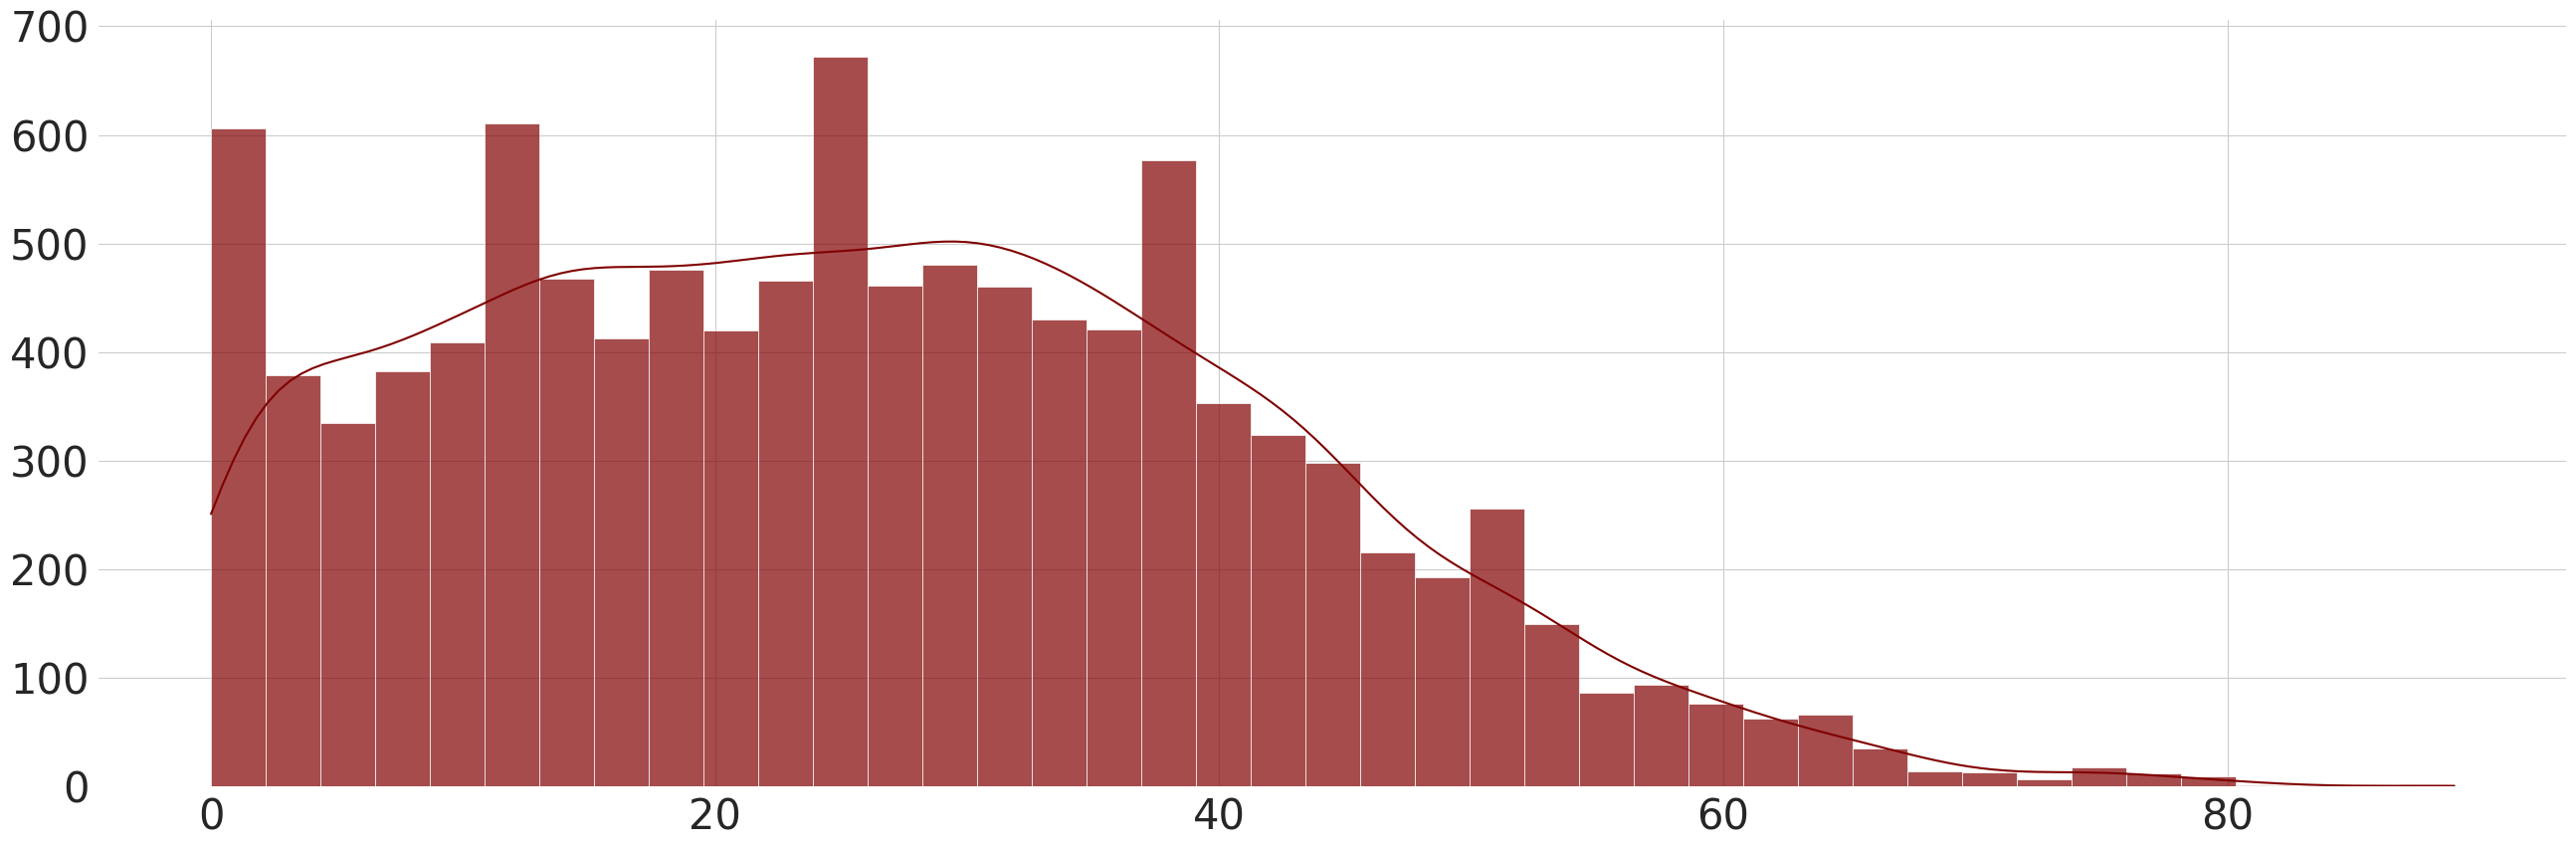

In [47]:
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(32,10))

ax = sns.histplot(data=audio, x='popularity',color='maroon', kde=True, alpha=0.7) #.set(title='Distribution of Popularity Scores');
ax.set(xlabel='', ylabel='')
print('As we can see from the plot below, the popularity score is a number in the range 0-80, where 80 is the score indicating the most popular song. \
Most of the songs on this dataset have a popularity score less than 40, deeming them as less popular.')
sns.despine(left=True, bottom=True)

## Genres 

We add the extra information about genres in the audio dataset.

In [48]:
genre_groups = pd.read_csv('genre_groups.csv') 
print(genre_groups.shape)
genre_groups.head()

(10753, 3)


GROUP_ID                       GENRE SUBGENRE
0   2159085  ['Rap/Hip-Hop', 'Hip-Hop']    [nan]
1   1582626             ['Rap/Hip-Hop']    [nan]
2   3443172             ['Rap/Hip-Hop']    [nan]
3   1768001              ['Electronic']    [nan]
4    614380               ['Brazilian']    [nan]

In [49]:
id_groups = pd.read_csv('id_groups.csv')
print(id_groups.shape)
id_groups.head()

(10753, 2)


GROUP_ID                                               id
0   2159085  00191018727130-1E2972E03795F64C6EBAA98DF947EC0E
1   1582626  00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6
2   3443172  00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB
3   1768001  00191018812614-770F9C647B13ABAEB610FB62191A1674
4    614380  00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583

In [50]:
genres = genre_groups.merge(id_groups, how='inner', on='GROUP_ID').drop_duplicates().drop('GROUP_ID', axis=1).rename(columns = lambda x: x.lower())
genres = genres.merge(audio[['id', 'popularity']], on='id', how='left')
genres.head()

genre subgenre  \
0  ['Rap/Hip-Hop', 'Hip-Hop']    [nan]   
1             ['Rap/Hip-Hop']    [nan]   
2             ['Rap/Hip-Hop']    [nan]   
3              ['Electronic']    [nan]   
4               ['Brazilian']    [nan]   

                                                id  popularity  
0  00191018727130-1E2972E03795F64C6EBAA98DF947EC0E         4.0  
1  00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6        37.0  
2  00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB        37.0  
3  00191018812614-770F9C647B13ABAEB610FB62191A1674        15.0  
4  00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583        39.0

In [51]:
#Clean Up
map_genre= {'alternative alternative indie':'alternative indie', 'alternative indie singer songwriter':'alternative indie', 'alternative rock alternative':'alternative rock',
          'alternative rock rock':'alternative rock', 'alternative singer songwriter':'alternative', 'alternativo & rock latino':'alternative rock', 'brazilian brazilian rap':'brazilian',
          "children's music":"childrens", 'dance dance house':'dance house', 'dance house':'dance', 'pop pop':'dance pop', 'electronica':'electronic', 'gospel christian':'gospel',
          'hip-hop rap hip-hop':'hip-hop rap', 'inspirational gospel christian':'inspirational gospel', 'hip-hop rap rap hip-hop':'hip-hop rap rap', 
           'pop singer songwriter':'pop', 'r&b r&b soul':'r&b soul', 'rap hip-hop hip-hop':'rap hip-hop', 'rap hip-hop rap':'rap hip-hop', 'rap hip-hop rap hip-hop':'rap hip-hop',
          'pop singer songwriter':'pop', 'R&B R&B Soul':'R&B Soul', 'Rap Hip-Hop Hip-Hop':'Rap Hip-Hop', 'Rap Hip-Hop Rap':'Rap Hip-Hop', 'Rap Hip-Hop Rap Hip-Hop':'Rap Hip-Hop',
          'soundtrack tv':'soundtrack', 'soundtracks soundtrack':'soundtrack', 'world music':'world', 'world music world':'world',
           "adult contemporary":'adult contemporary',  "alternative rock pop":"alternative rock", "electro house dance":"electro house", "electro house dance":'electro house',
          'dance, pop pop':"dance", "dance house techno singer songwriter":"dance house", "r & b soul":"r&b soul", "r&b soul alternative indie":"r&b soul", "soul r&b":'r&b soul',
          "southern rap hip-hop":"rap hip-hop", "international rap hip-hop":"rap hip-hop", "inspirational gospel":"gospel", 'r & b':'r&b',
           "black metal": "metal", "adult alternative": "adult", "adult contemporary": "adult", "adult contemporary (singer/songwriter)": "adult", "death metal": "metal", "r & b": "r&b", "internationale": "", "afro beat": "afro", "afro house": "afro", 
          "afro pop": "afro", "adult contemporary singer/songwriter": "adult", "alternative alternative": "alternative", "alternative alternative": "alternative", "country (contemporary)": "country", "contemporary christian": "gospel", 
          "blues contemporary": "blues", "brazilian rap": "brazilian", "brazilian brazilian": "brazilian", "children's music": "childrens", "classic rock": "rock", "dance electro house": "dance", "dance electronic": "dance",
           'electronica':'electronic', 'rock pop':'rock pop', 'r & b':'r&b',  "hip hop":"hip-hop"}
map_subgenre = {'Electronica':'Electronic', 'Rock pop':'Rock Pop', 'R & b':'R&B'}

In [52]:
nan = ''
genres['genre'] = [re.sub(r'[^A-Za-z0-9 &-]+', ' ', ",".join(eval(x)).lower()).replace('hip hop', 'hip-hop') for x in genres.genre] 
genres['subgenre'] = [re.sub(r'[^A-Za-z0-9 &-]+', ' ', ",".join(eval(x)).lower()) for x in genres.subgenre]


genres['genre'] = genres['genre'].apply(lambda x: map_genre.get(x, x))
genres['subgenre'] = genres['subgenre'].apply(lambda x: map_genre.get(x, x))
genres["all_genre"] = [f"{x} {y}" for x, y in zip(genres.genre, genres.subgenre)]
#temp['all_genres'] = [" ".join([word for word in temp.all_genres[i].split(" ") if len(word) > 1]) for i in range(len(temp.all_genres))]
genres["first"] = [x.split(" ")[0] for x in genres.all_genre]

In [53]:
genres.head()

genre subgenre                                               id  \
0  rap hip-hop           00191018727130-1E2972E03795F64C6EBAA98DF947EC0E   
1  rap hip-hop           00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6   
2  rap hip-hop           00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB   
3   electronic           00191018812614-770F9C647B13ABAEB610FB62191A1674   
4    brazilian           00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583   

   popularity     all_genre       first  
0         4.0  rap hip-hop          rap  
1        37.0  rap hip-hop          rap  
2        37.0  rap hip-hop          rap  
3        15.0   electronic   electronic  
4        39.0    brazilian    brazilian

In [54]:
genres['genre'].value_counts()

pop                                       1736
alternative                               1422
rap hip-hop                               1217
rock                                       833
dance                                      789
soundtrack                                 628
hip-hop                                    600
metal                                      422
electronic                                 359
r&b                                        303
brazilian                                  276
country                                    246
alternative rock                           178
singer songwriter                          158
reggae                                     128
schlager                                   119
french pop                                 119
latin                                       79
world                                       73
latin pop                                   73
rap                                         64
folk         

In [55]:
genres['subgenre'].value_counts()

                           8390
rock                        276
french                      182
pop                         173
rap                         134
score                       108
indie rock                  105
tv                           86
electronic                   85
house                        77
alternative                  76
latin urban                  69
soul                         61
metal                        57
funk                         55
singer songwriter            49
mandopop                     48
heavy                        41
progressive rock             38
r&b                          34
dance                        25
hip-hop                      25
chill out                    24
fado                         24
rock pop                     23
electro house                22
film movie                   18
gospel                       17
ambient                      16
regional   mexican           15
hard rock                    13
cantopop

### EDA 

In [56]:
genres['words_count'] = genres['first'].apply(lambda x: Counter(x.split(' ')))
gen_table=pd.DataFrame(genres.words_count.values.tolist())
gen_table[np.isnan(gen_table)] = 0
genres.drop('words_count', axis=1, inplace=True)

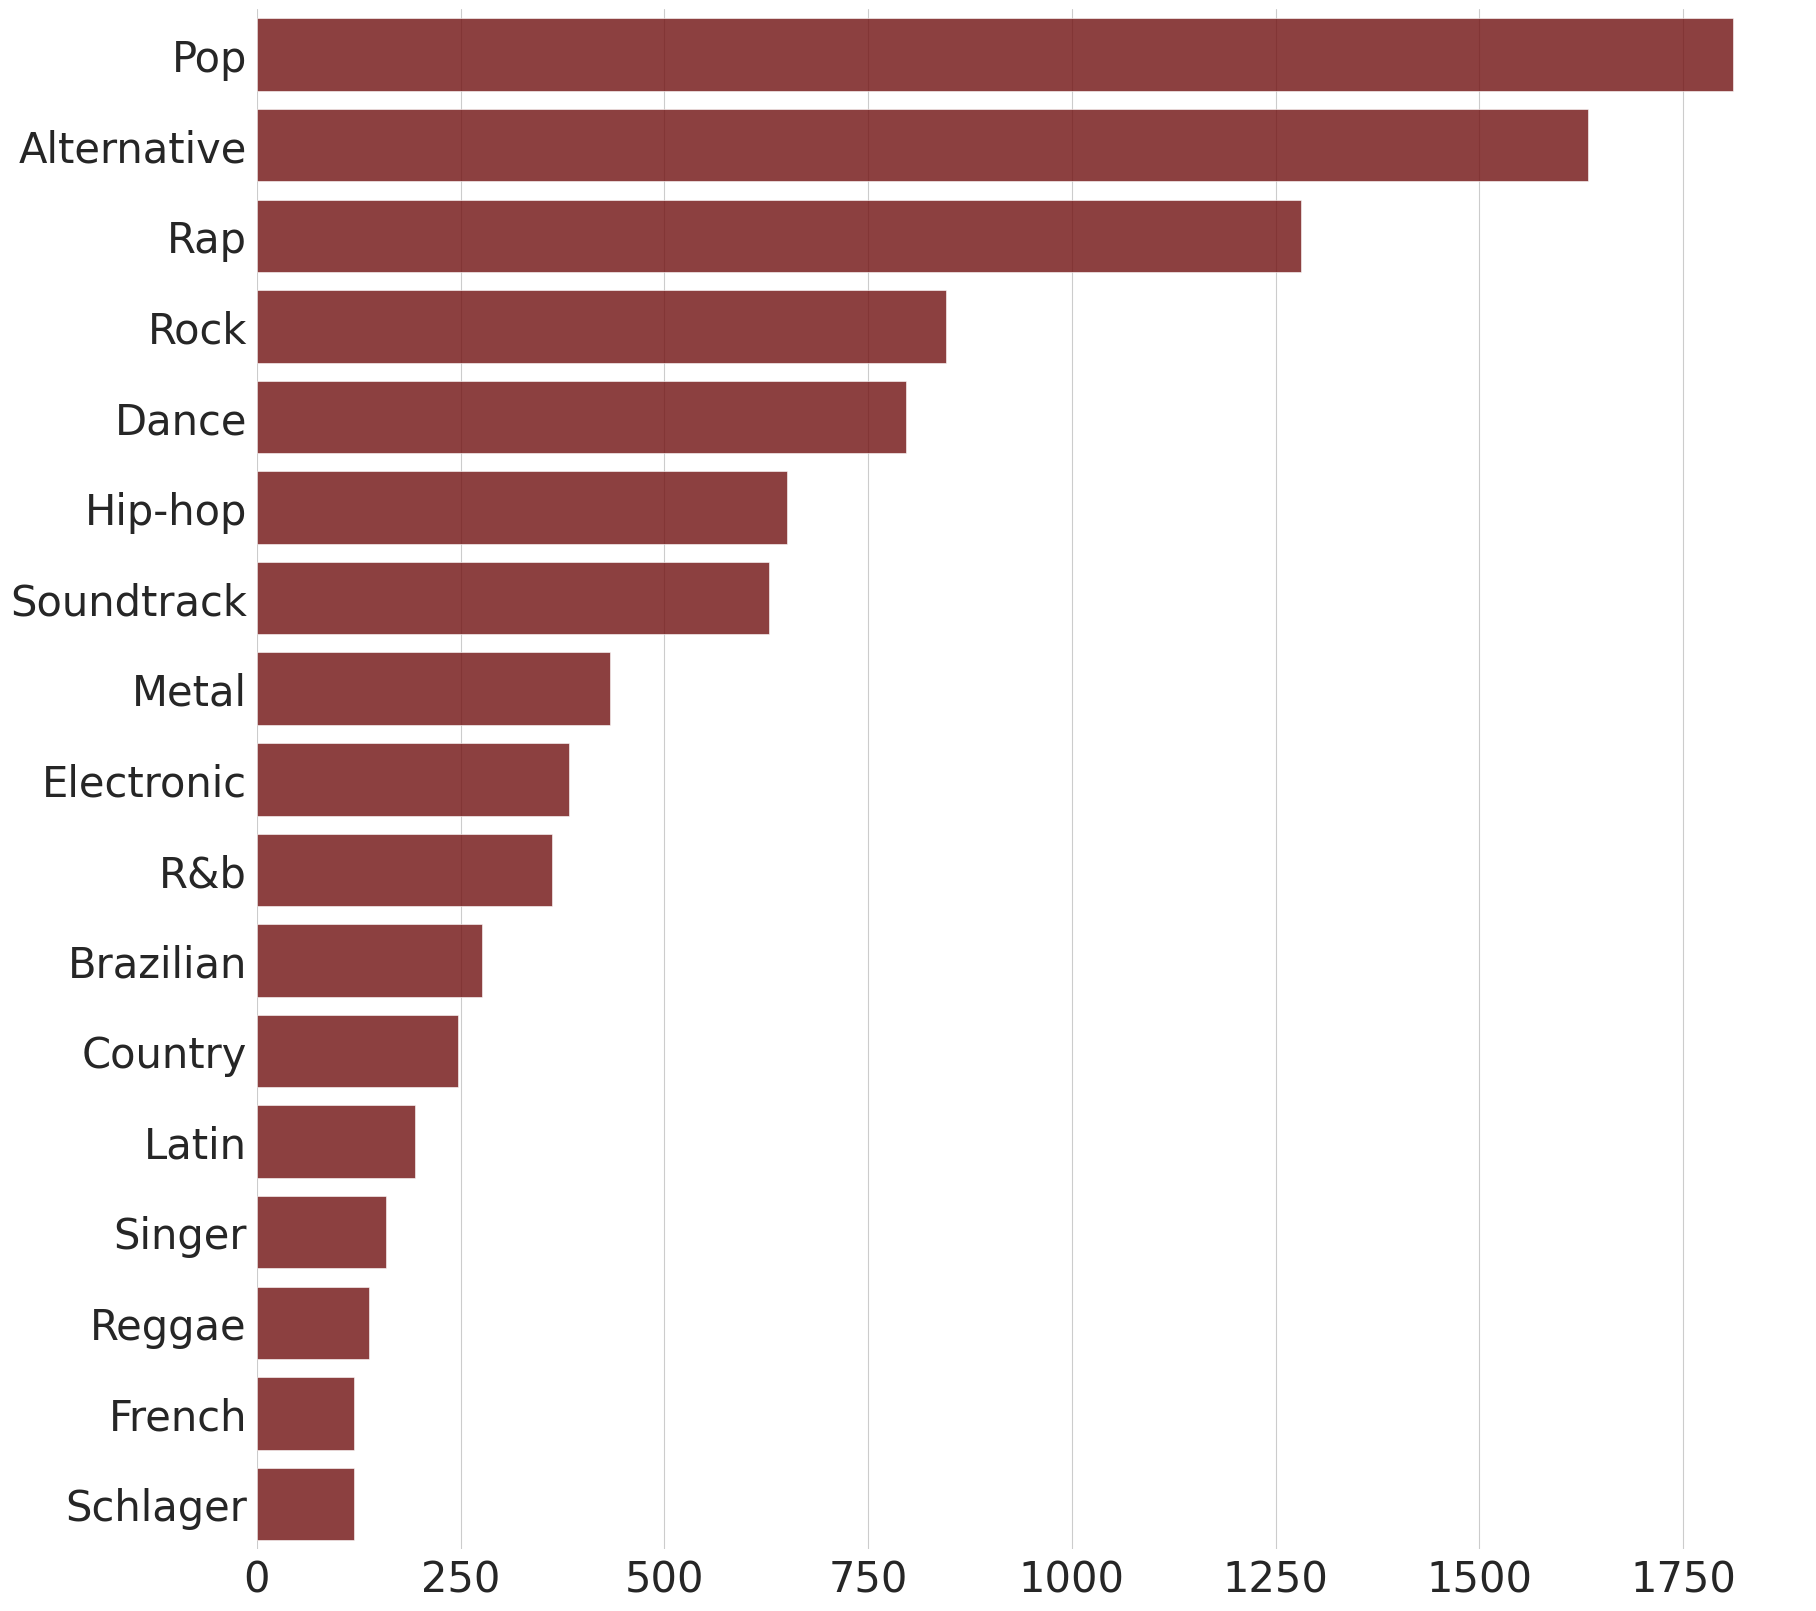

In [74]:
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))

gen = gen_table.sum().sort_values(ascending=True)
gen.index = gen.index.str.capitalize()
sns.barplot(y = gen[gen>100].iloc[::-1].index, x= gen[gen>100].sort_values(ascending=False), color='maroon', alpha=0.8,  orient = 'h')
#plt.xticks(rotation = 90)
plt.ylabel("")

sns.despine(left=True, bottom=True)

<AxesSubplot: xlabel='first', ylabel='popularity'>

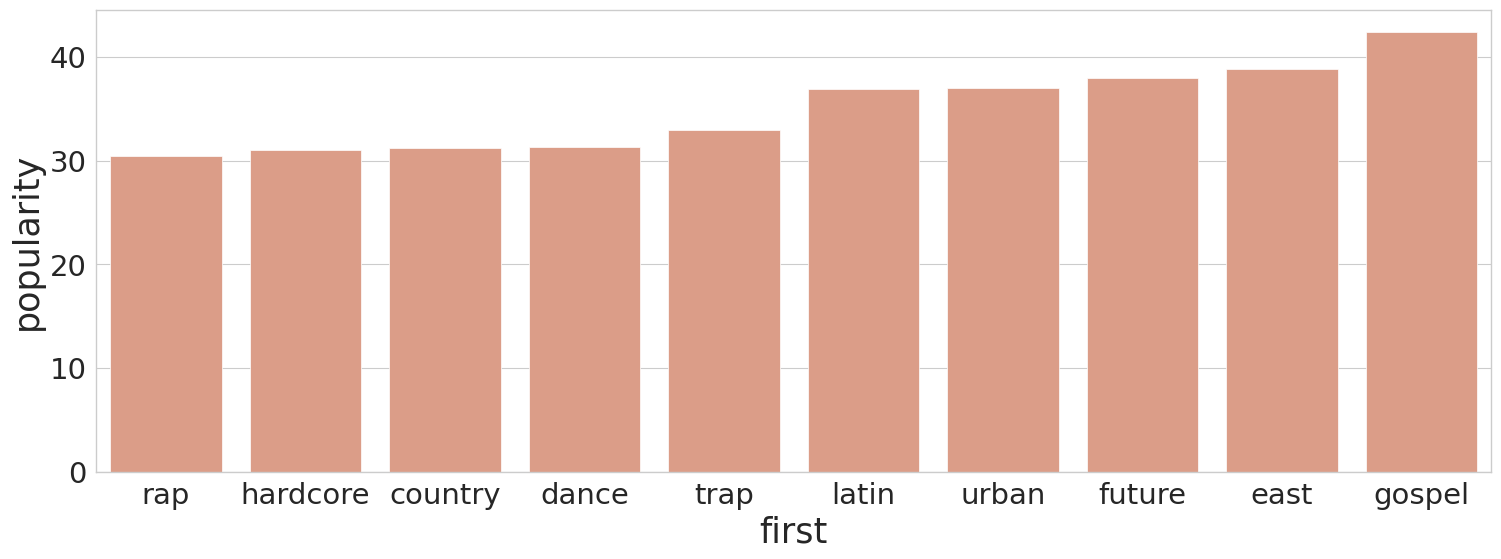

In [166]:
#Mean popularity per genre
dd = genres.groupby("first").agg({"genre": "count", "popularity": "mean"})
# dd.index.name = "genre"
sns.barplot(x= 'first', y='popularity', data=dd.sort_values("popularity").reset_index()[-10:],color='darksalmon')

<AxesSubplot: xlabel='first', ylabel='popularity'>

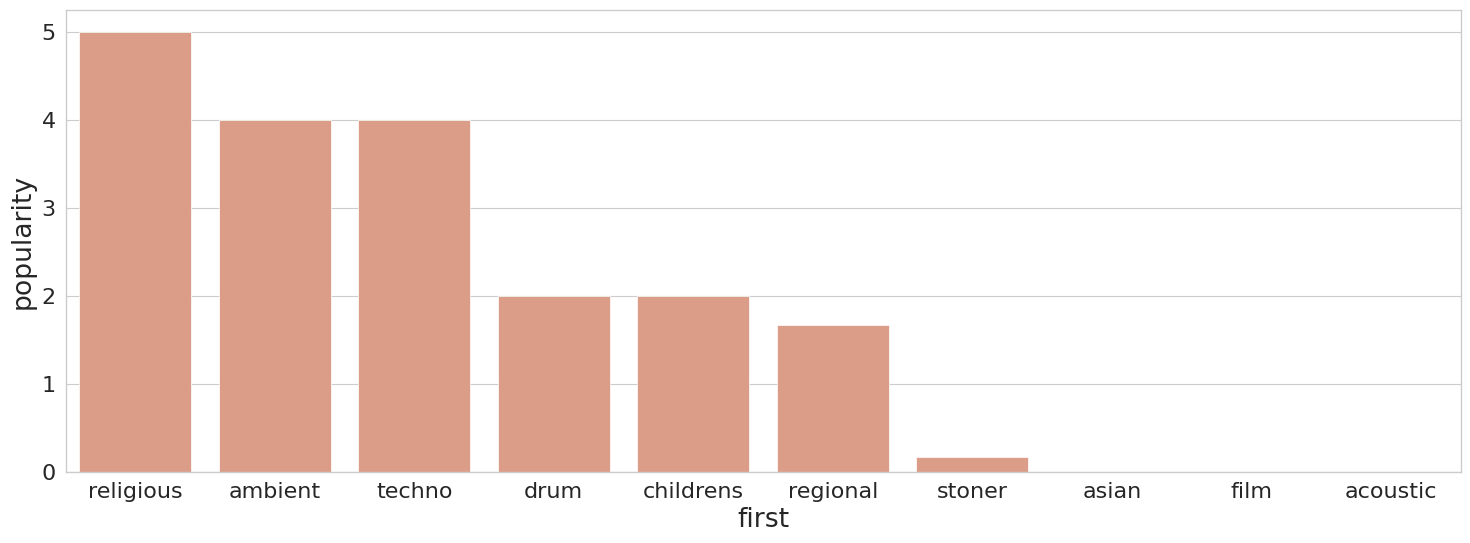

In [44]:
sns.barplot(x= 'first', y='popularity', data=dd.sort_values("popularity", ascending=False).reset_index()[-10:],color='darksalmon')

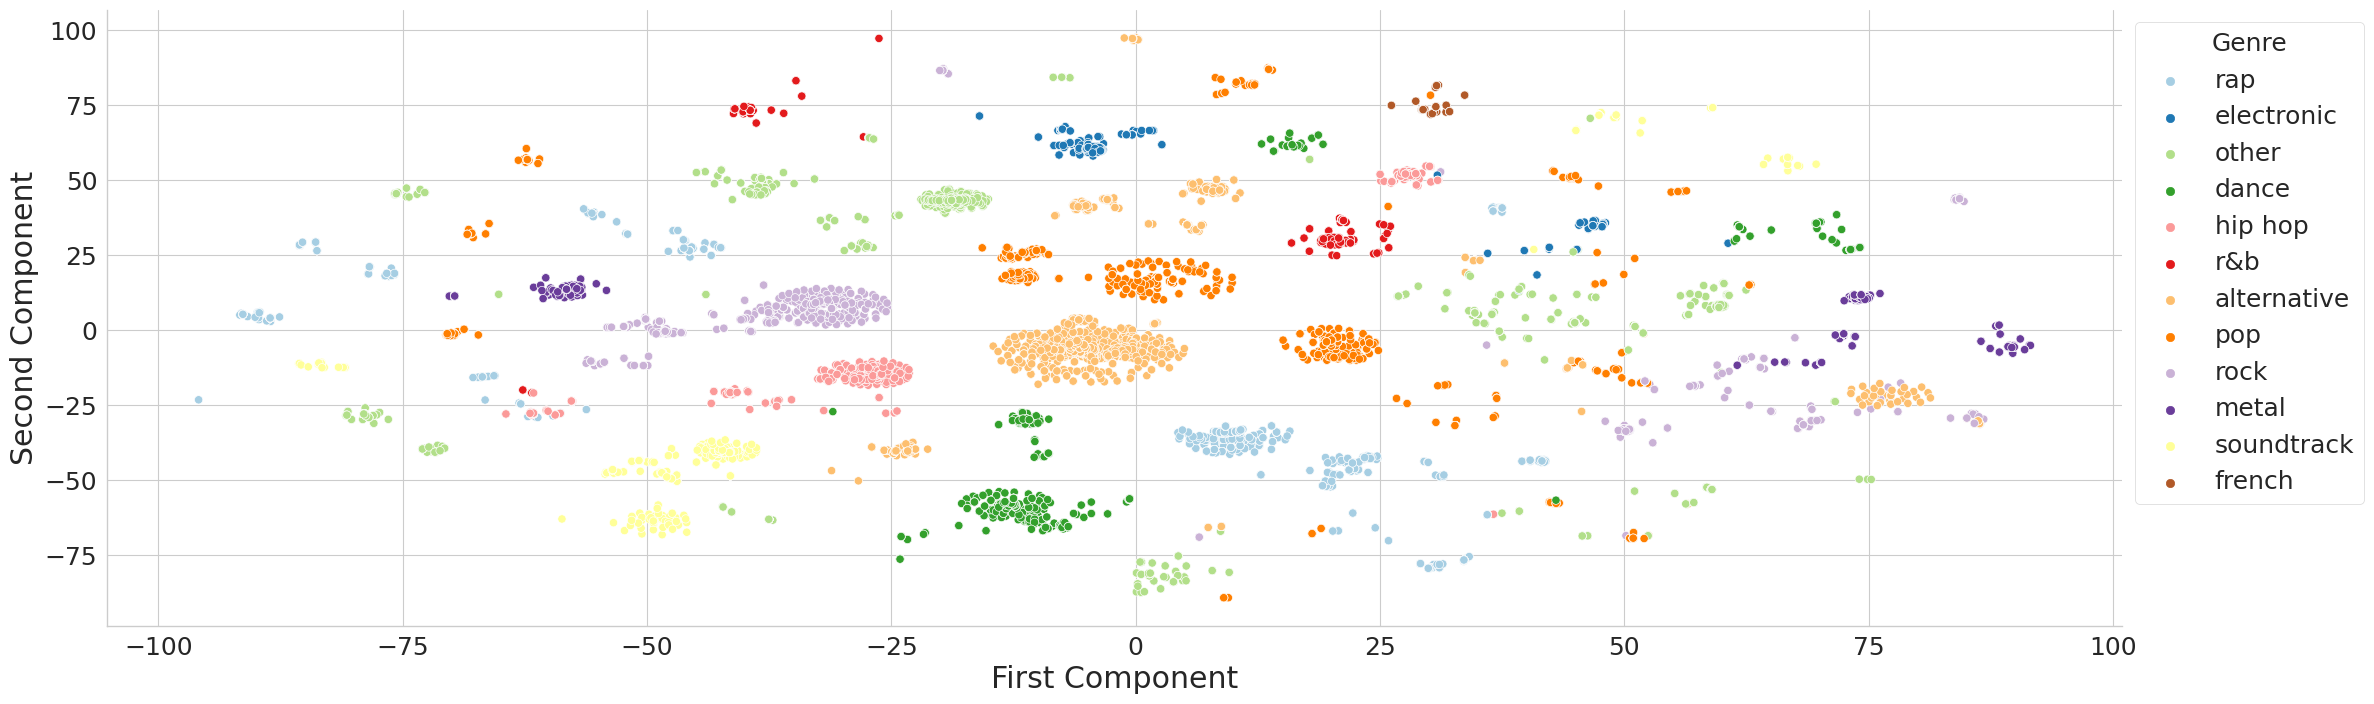

In [146]:
fig, ax = plt.subplots(figsize=(26, 8))
sns.scatterplot(x="First Component", y="Second Component", hue="Genre", data=tt, palette="Paired", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

### Dummies 

In [45]:
genres = pd.get_dummies(genres.set_index('id'), columns=['first'], drop_first=True).iloc[:,4:]
genres.head()

first_adult  first_afro  \
id                                                                         
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E            0           0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6            0           0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB            0           0   
00191018812614-770F9C647B13ABAEB610FB62191A1674            0           0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583            0           0   

                                                 first_alternative  \
id                                                                   
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E                  0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6                  0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB                  0   
00191018812614-770F9C647B13ABAEB610FB62191A1674                  0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583                  0   

                                                 first_ambient  \
id                                                               
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E              0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6              0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB              0   
00191018812614-770F9C647B13ABAEB610FB62191A1674              0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583              0   

                                                 first_americana  first_asian  \
id                                                                              
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E                0            0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6                0            0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB                0            0   
00191018812614-770F9C647B13ABAEB610FB62191A1674                0            0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583                0            0   

                                                 first_avant  first_bluegrass  \
id                                                                              
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E            0                0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6            0                0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB            0                0   
00191018812614-770F9C647B13ABAEB610FB62191A1674            0                0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583            0                0   

                                                 first_blues  first_brazilian  \
id                                                                              
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E            0                0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6            0                0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB            0                0   
00191018812614-770F9C647B13ABAEB610FB62191A1674            0                0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583            0                1   

                                                 ...  first_soundtrack  \
id                                               ...                     
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E  ...                 0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6  ...                 0   
00191018762636-BCFE527FE3989A291B4291CD8CD3F6AB  ...                 0   
00191018812614-770F9C647B13ABAEB610FB62191A1674  ...                 0   
00191773064532-7874C3F7EAFDBC4FE5128FBA02A72583  ...                 0   

                                                 first_spoken  first_stoner  \
id                                                                            
00191018727130-1E2972E03795F64C6EBAA98DF947EC0E             0             0   
00191018727130-93DB1532FAAFE1C039D7FA49808C1CC6             0             0   
00191018762636-BCFE527F

### Doc2Vec & BERT

In [16]:
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /home/kostas/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [167]:
corpus_text = ".\n".join(genres["all_genre"])
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)
for i, d in enumerate(data):
    data[i] = [x for x in d if (x != ".") and (len(x) > 1)]

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(data)]

In [168]:
"""
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
"""
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, epochs=100)
model.wv.most_similar("pop")

[('indie', 0.5067721009254456),
 ('progressive', 0.41842761635780334),
 ('religious', 0.3958073556423187),
 ('holiday', 0.39548954367637634),
 ('tropical', 0.39543724060058594),
 ('electropop', 0.39539632201194763),
 ('drum', 0.3839445114135742),
 ('comedy', 0.3778310716152191),
 ('punk', 0.355498343706131),
 ('hip-hop', 0.3493042588233948)]

In [169]:
bert_model = SentenceTransformer("bert-base-nli-mean-tokens", device="cpu")

In [170]:
sentence_embeddings = bert_model.encode(genres['all_genre'].str.replace(",", " "))
print(sentence_embeddings.shape, sentence_embeddings.dtype)

(10753, 768) float32


In [171]:
#scaler = StandardScaler()
#sentence_embeddings = scaler.fit_transform(sentence_embeddings)
#print(sentence_embeddings.shape)

pca = PCA(n_components=0.95)
embeddings = pca.fit_transform(sentence_embeddings)
print(embeddings.shape)

(10753, 28)


In [172]:
tsne = TSNE(n_jobs=-1)
res = tsne.fit_transform(sentence_embeddings)
print(res.shape)
res = pd.DataFrame(res)
res.columns = ["First Component", "Second Component"]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(10753, 2)


In [173]:
tt = res.copy()
tt["Genre"] = ["pop" if x.startswith("pop") else "other" for x in genres.all_genre]

for i, x in enumerate(genres.genre.values.tolist()):
    if "pop" in x:
        tt.loc[i, "Genre"] = "pop"
    if "hip" in x:
        tt.loc[i, "Genre"] = "hip hop"
    if "alterna" in x:
        tt.loc[i, "Genre"] = "alternative"
    if "rock" in x:
        tt.loc[i, "Genre"] = "rock"
    if "rap" in x:
        tt.loc[i, "Genre"] = "rap"
    if "dance" in x:
        tt.loc[i, "Genre"] = "dance"
    if "soundtrack" in x:
        tt.loc[i, "Genre"] = "soundtrack"
    if "metal" in x:
        tt.loc[i, "Genre"] = "metal"
    if "electronic" in x:
        tt.loc[i, "Genre"] = "electronic"
    if "r&b" in x:
        tt.loc[i, "Genre"] = "r&b"
    if "french" in x:
        tt.loc[i, "Genre"] = "french"

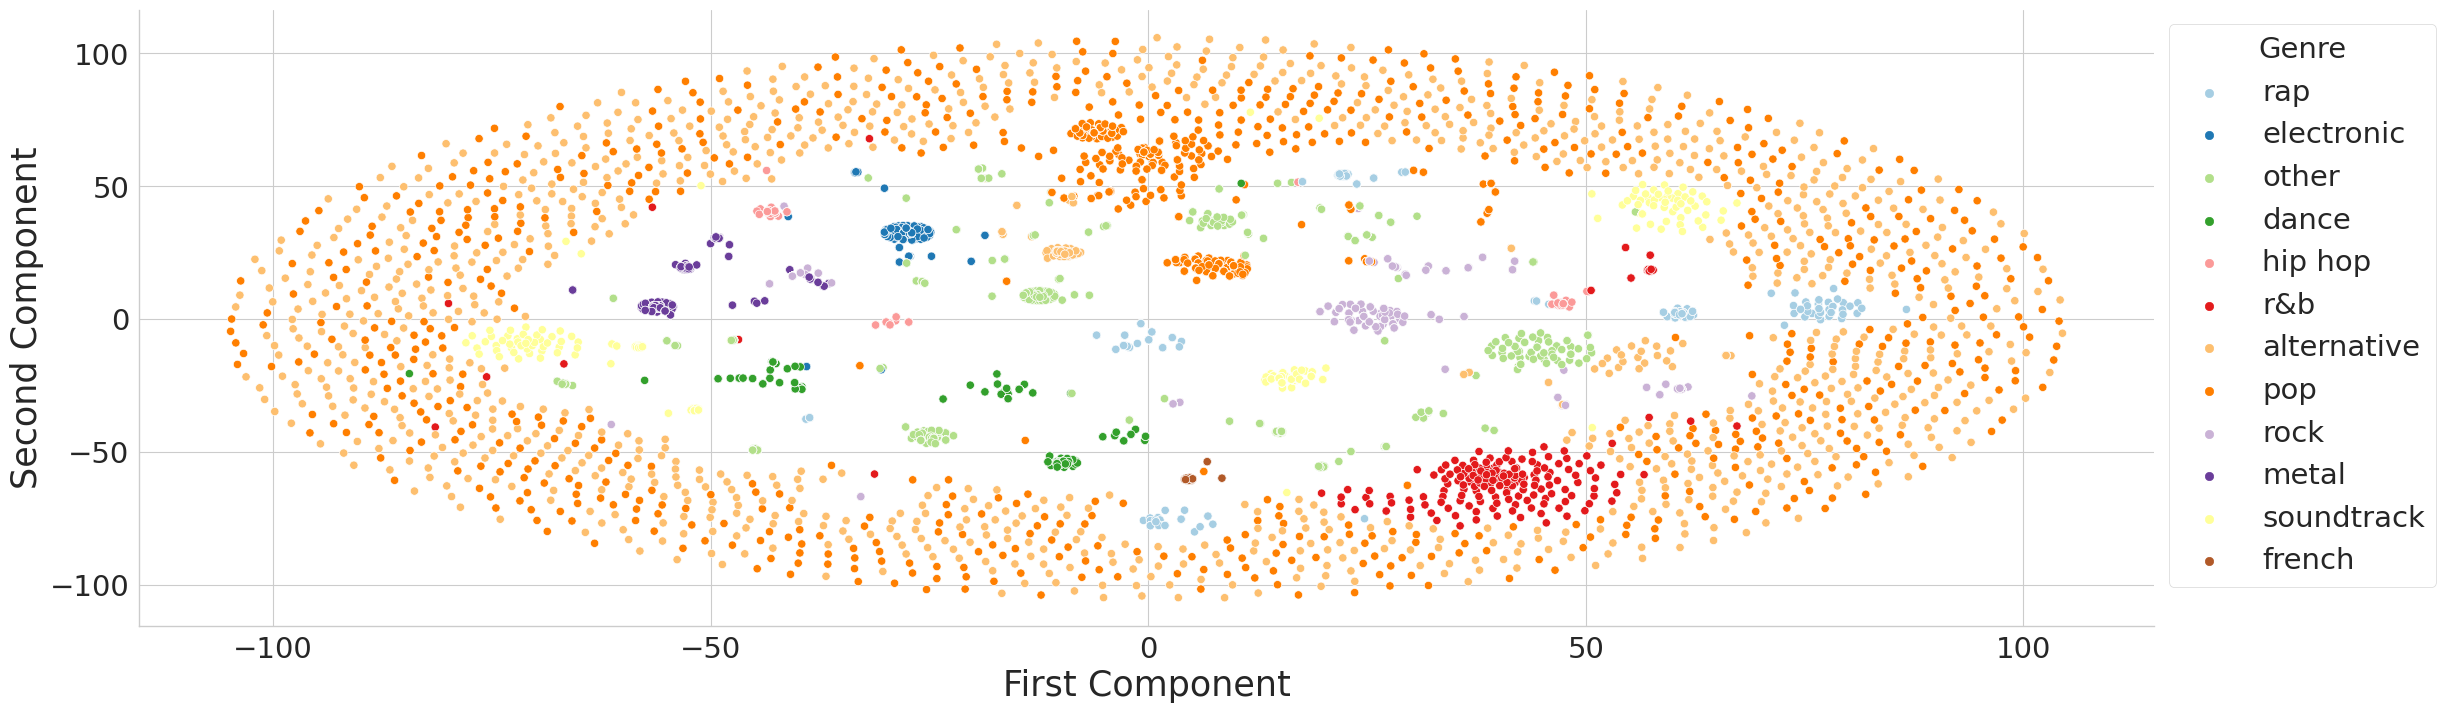

In [174]:
fig, ax = plt.subplots(figsize=(26, 8))
sns.scatterplot(x="First Component", y="Second Component", hue="Genre", data=tt, palette="Paired", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

## Train-Validation-Test Split: Regression

In [46]:
audio.set_index('id', inplace=True)

#Spotify
X_audio_train = audio.iloc[:int(audio.shape[0] * 0.8)].drop('popularity', axis=1) #keep 80% of sorted data as train
X_audio_val = audio.iloc[int(audio.shape[0] * 0.8):int(audio.shape[0] * 0.9)].drop('popularity', axis=1) # 10% validation 
X_audio_test = audio.iloc[int(audio.shape[0] * 0.9):].drop('popularity', axis=1) # 10% test

#Golden Truth
y_train = audio.loc[X_audio_train.index].popularity
y_val = audio.loc[X_audio_val.index].popularity
y_test = audio.loc[X_audio_test.index].popularity

#Genres
X_genres_train = genres.loc[X_audio_train.index] 
X_genres_val = genres.loc[X_audio_val.index] 
X_genres_test = genres.loc[X_audio_test.index] 

#Mel Spectrograms
X_mel_train = all_spectrograms.loc[X_audio_train.index]
X_mel_val = all_spectrograms.loc[X_audio_val.index]
X_mel_test = all_spectrograms.loc[X_audio_test.index]
remaining_spectrograms = all_spectrograms[~all_spectrograms.index.isin(audio.index.unique())]

#MFCCS
X_mel_features_train = mfccs.loc[X_audio_train.index]
X_mel_features_val = mfccs.loc[X_audio_val.index]
X_mel_features_test = mfccs.loc[X_audio_test.index]

In [47]:
#Delete Variables to clean up memory
del all_spectrograms, mfccs, delta_1, delta_2

### Check for correct order

In [48]:
print(X_audio_test.shape)
X_audio_test.head()

(1076, 28)


explicit  acousticness  \
id                                                                      
840588119721-6f903c10d351197af69b81cfef2c99db         0      0.000018   
190296917592-e0f460426251635a99dd5214b63124fe         1      0.008990   
190295310462-21984f57add4fa54282a8dd36cab16e8         0      0.690000   
075679862662-51c6d29d787ad6977c94eccca91bd185         0      0.025500   
840588117086-eaf5f4793a66f81e0720282eb681f11e         1      0.000111   

                                               danceability  energy  \
id                                                                    
840588119721-6f903c10d351197af69b81cfef2c99db         0.551   0.916   
190296917592-e0f460426251635a99dd5214b63124fe         0.539   0.631   
190295310462-21984f57add4fa54282a8dd36cab16e8         0.610   0.492   
075679862662-51c6d29d787ad6977c94eccca91bd185         0.428   0.861   
840588117086-eaf5f4793a66f81e0720282eb681f11e         0.398   0.961   

                                               instrumentalness  liveness  \
id                                                                          
840588119721-6f903c10d351197af69b81cfef2c99db          0.410000     0.334   
190296917592-e0f460426251635a99dd5214b63124fe          0.000000     0.132   
190295310462-21984f57add4fa54282a8dd36cab16e8          0.000055     0.123   
075679862662-51c6d29d787ad6977c94eccca91bd185          0.000102     0.116   
840588117086-eaf5f4793a66f81e0720282eb681f11e          0.000506     0.306   

                                               loudness  mode  speechiness  \
id                                                                           
840588119721-6f903c10d351197af69b81cfef2c99db    -2.540   0.0       0.0424   
190296917592-e0f460426251635a99dd5214b63124fe    -7.673   1.0       0.3930   
190295310462-21984f57add4fa54282a8dd36cab16e8    -7.198   0.0       0.0401   
075679862662-51c6d29d787ad6977c94eccca91bd185    -3.968   1.0       0.0840   
840588117086-eaf5f4793a66f81e0720282eb681f11e    -4.531   1.0       0.1850   

                                                 tempo  ...  key_2.0  key_3.0  \
id                                                      ...                     
840588119721-6f903c10d351197af69b81cfef2c99db  116.995  ...        0        0   
190296917592-e0f460426251635a99dd5214b63124fe   88.426  ...        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8  104.723  ...        0        0   
075679862662-51c6d29d787ad6977c94eccca91bd185  162.954  ...        0        0   
840588117086-eaf5f4793a66f81e0720282eb681f11e  179.042  ...        0        0   

                                               key_4.0  key_5.0  key_6.0  \
id                                                                         
840588119721-6f903c10d351197af69b81cfef2c99db        0        0        0   
190296917592-e0f460426251635a99dd5214b63124fe        0        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8        0        0        0   
075679862662-51c6d29d787ad6977c94eccca91bd185        0        0        0   
840588117086-eaf5f4793a66f81e0720282eb681f11e        0        0        0   

                                               key_7.0  key_8.0  key_9.0  \
id                                                                         
840588119721-6f903c10d351197af69b81cfef2c99db        0        0        1   
190296917592-e0f460426251635a99dd5214b63124fe        0        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8        0        0        1   
075679862662-51c6d29d787ad6977c94eccca91bd185        0        0        1   
840588117086-eaf5f4793a66f81e0720282eb681f11e        0        0        0   

                                               key_10.0  key_11.0  
id                                                                 
840588119721-6f903c10d351197af69b81cfef2c99db         0         0  
190296917592-e0f460426251635a99dd5214b63124fe         1         0  
190295310462-21984f57add4fa54282a8dd36cab16e

In [49]:
print(X_genres_test.shape)
X_genres_test.head()

(1076, 84)


first_adult  first_afro  \
id                                                                       
840588119721-6f903c10d351197af69b81cfef2c99db            0           0   
190296917592-e0f460426251635a99dd5214b63124fe            0           0   
190295310462-21984f57add4fa54282a8dd36cab16e8            0           0   
075679862662-51c6d29d787ad6977c94eccca91bd185            0           0   
840588117086-eaf5f4793a66f81e0720282eb681f11e            0           0   

                                               first_alternative  \
id                                                                 
840588119721-6f903c10d351197af69b81cfef2c99db                  1   
190296917592-e0f460426251635a99dd5214b63124fe                  0   
190295310462-21984f57add4fa54282a8dd36cab16e8                  0   
075679862662-51c6d29d787ad6977c94eccca91bd185                  1   
840588117086-eaf5f4793a66f81e0720282eb681f11e                  0   

                                               first_ambient  first_americana  \
id                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db              0                0   
190296917592-e0f460426251635a99dd5214b63124fe              0                0   
190295310462-21984f57add4fa54282a8dd36cab16e8              0                0   
075679862662-51c6d29d787ad6977c94eccca91bd185              0                0   
840588117086-eaf5f4793a66f81e0720282eb681f11e              0                0   

                                               first_asian  first_avant  \
id                                                                        
840588119721-6f903c10d351197af69b81cfef2c99db            0            0   
190296917592-e0f460426251635a99dd5214b63124fe            0            0   
190295310462-21984f57add4fa54282a8dd36cab16e8            0            0   
075679862662-51c6d29d787ad6977c94eccca91bd185            0            0   
840588117086-eaf5f4793a66f81e0720282eb681f11e            0            0   

                                               first_bluegrass  first_blues  \
id                                                                            
840588119721-6f903c10d351197af69b81cfef2c99db                0            0   
190296917592-e0f460426251635a99dd5214b63124fe                0            0   
190295310462-21984f57add4fa54282a8dd36cab16e8                0            0   
075679862662-51c6d29d787ad6977c94eccca91bd185                0            0   
840588117086-eaf5f4793a66f81e0720282eb681f11e                0            0   

                                               first_brazilian  ...  \
id                                                              ...   
840588119721-6f903c10d351197af69b81cfef2c99db                0  ...   
190296917592-e0f460426251635a99dd5214b63124fe                0  ...   
190295310462-21984f57add4fa54282a8dd36cab16e8                0  ...   
075679862662-51c6d29d787ad6977c94eccca91bd185                0  ...   
840588117086-eaf5f4793a66f81e0720282eb681f11e                0  ...   

                                               first_soundtrack  first_spoken  \
id                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db                 0             0   
190296917592-e0f460426251635a99dd5214b63124fe                 0             0   
190295310462-21984f57add4fa54282a8dd36cab16e8                 0             0   
075679862662-51c6d29d787ad6977c94eccca91bd185                 0             0   
840588117086-eaf5f4793a66f81e0720282eb681f11e                 0             0   

                                               first_stoner  first_surf  \
id                                                                        
840588119721-6f903c10d351197af69b81cfef2c99db             0           0   
190296917592-e0f460426251635a99dd5214b63124fe             0           0   
190295310462-21984f57add4fa54282a8dd3

In [50]:
print(X_mel_test.shape)
X_mel_test.head() 

(1076, 1)


mel_spectrogram
id                                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db  [[-67.84694, -63.592712, -66.010506, -69.13367...
190296917592-e0f460426251635a99dd5214b63124fe  [[-29.146584, -11.293348, -6.6665864, -5.09610...
190295310462-21984f57add4fa54282a8dd36cab16e8  [[-20.936728, -15.791068, 14.598892, 24.113197...
075679862662-51c6d29d787ad6977c94eccca91bd185  [[-55.457035, -46.74417, -30.082472, -27.92501...
840588117086-eaf5f4793a66f81e0720282eb681f11e  [[-100.0, -68.58247, -60.25743, -58.777393, -5...

In [51]:
print(len(y_test))
y_test.head()

1076


id
840588119721-6f903c10d351197af69b81cfef2c99db    26.0
190296917592-e0f460426251635a99dd5214b63124fe    52.0
190295310462-21984f57add4fa54282a8dd36cab16e8    28.0
075679862662-51c6d29d787ad6977c94eccca91bd185    46.0
840588117086-eaf5f4793a66f81e0720282eb681f11e    37.0
Name: popularity, dtype: float64

### Standardizing 

In [52]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [53]:
#Scale Audio Data
scaler = MinMaxScaler()
X_audio_train = pd.DataFrame(scaler.fit_transform(X_audio_train), index=X_audio_train.index, columns=X_audio_train.columns)
X_audio_val = pd.DataFrame(scaler.transform(X_audio_val), index=X_audio_val.index, columns=X_audio_val.columns)
X_audio_test = pd.DataFrame(scaler.transform(X_audio_test), index=X_audio_test.index, columns=X_audio_test.columns)

#Scale MFCCs
scaler = MinMaxScaler()
X_mel_features_train = pd.DataFrame(scaler.fit_transform(X_mel_features_train), index=X_mel_features_train.index, columns=X_mel_features_train.columns)
X_mel_features_val = pd.DataFrame(scaler.transform(X_mel_features_val), index=X_mel_features_val.index, columns=X_mel_features_val.columns)
X_mel_features_test = pd.DataFrame(scaler.transform(X_mel_features_test), index=X_mel_features_test.index, columns=X_mel_features_test.columns)

###  Train-Validation-Test Split & Standardizing (YouTube Views)

Youtube Views will be used both as static features as well as a time series. Due to the nature of their initial dataset, their split into train, validation and test will be different than the split above.

#### Static Features 

In [56]:
scaler = MinMaxScaler()
kbest = SelectKBest(mutual_info_regression, k=20) #we use SelectKBest to keep feature names

pop = popularity.set_index('id')[['TOTAL_VIEWS','PEAK_VIEWS','DATE']].sort_values(by=['id','DATE']).reset_index() 
X_static_views = extract_features(pop, column_id="id", column_sort="DATE", default_fc_parameters=MinimalFCParameters())
X_static_views = X_static_views.replace([np.inf, -np.inf], np.nan).dropna(axis=1).reset_index().rename({'index' : 'id'},axis=1).merge(trends, on='id', how='left').set_index('id')

X_static_views_train = pd.DataFrame(kbest.fit_transform(X_static_views.loc[X_audio_train.index], y_train), 
                                    index=X_static_views.loc[X_audio_train.index].index, 
                                    columns=X_static_views.loc[X_audio_train.index].columns[kbest.get_support(1)]) 
X_static_views_train = pd.DataFrame(scaler.fit_transform(X_static_views_train), index=X_static_views_train.index, columns=X_static_views_train.columns)

X_static_views_val = pd.DataFrame(kbest.transform(X_static_views.loc[X_audio_val.index]), 
                                  index=X_static_views.loc[X_audio_val.index].index, 
                                  columns=X_static_views.loc[X_audio_val.index].columns[kbest.get_support(1)]) 
X_static_views_val = pd.DataFrame(scaler.transform(X_static_views_val), index=X_static_views_val.index, columns=X_static_views_val.columns)

X_static_views_test = pd.DataFrame(kbest.transform(X_static_views.loc[X_audio_test.index]), 
                                   index=X_static_views.loc[X_audio_test.index].index, 
                                   columns=X_static_views.loc[X_audio_test.index].columns[kbest.get_support(1)]) 
X_static_views_test = pd.DataFrame(scaler.transform(X_static_views_test), index=X_static_views_test.index, columns=X_static_views_test.columns)

Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.41it/s]


In [57]:
X_static_views_train.columns

Index(['TOTAL_VIEWS__sum_values', 'TOTAL_VIEWS__median', 'TOTAL_VIEWS__mean',
       'TOTAL_VIEWS__standard_deviation', 'TOTAL_VIEWS__variance',
       'TOTAL_VIEWS__root_mean_square', 'TOTAL_VIEWS__maximum',
       'TOTAL_VIEWS__absolute_maximum', 'PEAK_VIEWS__sum_values',
       'PEAK_VIEWS__median', 'PEAK_VIEWS__mean',
       'PEAK_VIEWS__standard_deviation', 'PEAK_VIEWS__variance',
       'PEAK_VIEWS__root_mean_square', 'PEAK_VIEWS__maximum',
       'PEAK_VIEWS__absolute_maximum', 'PEAK_VIEWS__minimum',
       'TOTAL_VIEWS_coef', 'PEAK_VIEWS_coef', 'TOTAL_VIEWS_coef_12'],
      dtype='object')

#### Time Series 

In [58]:
scaler = StandardScaler()

train_pop = popularity.set_index('id').loc[X_audio_train.index][['TOTAL_VIEWS','PEAK_VIEWS','DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
train_pop = pd.DataFrame(scaler.fit_transform(train_pop),  index=train_pop.index, columns=train_pop.columns)
X_views_train = pd.DataFrame(index = train_pop.index.unique()).reset_index()
X_views_train['TOTAL_VIEWS'] = train_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_train['PEAK_VIEWS'] = train_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_train['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_train.TOTAL_VIEWS, X_views_train.PEAK_VIEWS)]

val_pop = popularity.set_index('id').loc[X_audio_val.index][['TOTAL_VIEWS','PEAK_VIEWS', 'DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
val_pop = pd.DataFrame(scaler.transform(val_pop),  index=val_pop.index, columns=val_pop.columns)
X_views_val = pd.DataFrame(index = val_pop.index.unique()).reset_index()
X_views_val['TOTAL_VIEWS'] = val_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_val['PEAK_VIEWS'] = val_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_val['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_val.TOTAL_VIEWS, X_views_val.PEAK_VIEWS)]

test_pop = popularity.set_index('id').loc[X_audio_test.index][['TOTAL_VIEWS','PEAK_VIEWS', 'DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
test_pop = pd.DataFrame(scaler.transform(test_pop),  index=test_pop.index, columns=test_pop.columns)
X_views_test = pd.DataFrame(index = test_pop.index.unique()).reset_index()
X_views_test['TOTAL_VIEWS'] = test_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_test['PEAK_VIEWS'] = test_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_test['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_test.TOTAL_VIEWS, X_views_test.PEAK_VIEWS)]

###### Check for correct order

In [59]:
#Fix order of songs
X_views_train = X_audio_train.merge(X_views_train, on='id', how='left')[['id', 'VIEWS']]
X_views_train = np.array([x for x in X_views_train.VIEWS]).transpose((0,2,1)).reshape(X_views_train.shape[0], 41, 2)

X_views_val = X_audio_val.merge(X_views_val, on='id', how='left')[['id', 'VIEWS']]
X_views_val = np.array([x for x in X_views_val.VIEWS]).transpose((0,2,1)).reshape(X_views_val.shape[0], 41, 2)

X_views_test = X_audio_test.merge(X_views_test, on='id', how='left')[['id', 'VIEWS']]
X_views_test = np.array([x for x in X_views_test.VIEWS]).transpose((0,2,1)).reshape(X_views_test.shape[0], 41, 2)

In [60]:
popularity[popularity.id == X_audio_train.index[0]]

id  MONTH  YEAR  \
91102  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      3  2021   
91103  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      5  2019   
91104  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      2  2020   
91105  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      5  2021   
91106  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     11  2021   
91107  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     11  2019   
91108  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      3  2020   
91109  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      4  2020   
91110  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     10  2020   
91111  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     11  2020   
91112  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      7  2021   
91113  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     12  2021   
91114  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      4  2019   
91115  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      7  2019   
91116  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      8  2021   
91117  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     10  2021   
91118  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     12  2020   
91119  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      2  2021   
91120  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      1  2022   
91121  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      2  2022   
91122  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      2  2019   
91123  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      1  2019   
91124  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      9  2019   
91125  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      8  2020   
91126  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      4  2021   
91127  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      6  2021   
91128  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      9  2021   
91129  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      4  2022   
91130  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      5  2022   
91131  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      6  2019   
91132  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      8  2019   
91133  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     10  2019   
91134  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a     12  2019   
91135  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      1  2020   
91136  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      9  2020   
91137  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      1  2021   
91138  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      3  2022   
91139  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      3  2019   
91140  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      6  2020   
91141  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      5  2020   
91142  085365721913-1a23f5b7a067b4a677e4ea565ebdf64a      7  2020   

      release_date  TOTAL_VIEWS  PEAK_VIEWS       DATE  
91102   2018-09-28           67          43 2021-03-01  
91103   2018-09-28           16           9 2019-05-01  
91104   2018-09-28           42          20 2020-02-01  
91105   2018-09-28           64          34 2021-05-01  
91106   2018-09-28           94          35 2021-11-01  
91107   2018-09-28           18           8 2019-11-01  
91108   2018-09-28           24          15 2020-03-01  
91109   2018-09-28           34          20 2020-04-01  
91110   2018-09-28           89          41 2020-10-01  
91111   2018-09-28           90          45 2020-11-01  
91112   2018-09-28           75          49 2021-07-01  
91113   2018-09-28           75          39 2021-12-01  
91114   2018-09-28           18          11 2019-04-01  
91115   2018-09-28           31          20 2019-07-01  
91116   2018-09-28           92          50 2021-08-01  
91117   2018-09-28           96          35 2021-10-01  
91118   2018-09-28           71          28 2020-12-01  
91119   2018-09-28           56          31 2021-02-01  
91120   2018-09-28           64          37 2022-01-01  
91121   201

In [61]:
train_pop[train_pop.index == '085365721913-1a23f5b7a067b4a677e4ea565ebdf64a']

TOTAL_VIEWS  PEAK_VIEWS
id                                                                    
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066339   -0.090554
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066347   -0.090623
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066345   -0.090530
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066349   -0.090616
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066349   -0.090631
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066348   -0.090577
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066344   -0.090546
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066343   -0.090507
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066348   -0.090616
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066342   -0.090561
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066349   -0.090639
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066346   -0.090592
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066349   -0.090639
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066341   -0.090546
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066347   -0.090585
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066344   -0.090546
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066336   -0.090507
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066344   -0.090585
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066334   -0.090422
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066343   -0.090523
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066334   -0.090430
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066326   -0.090384
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066326   -0.090353
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066332   -0.090484
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066326   -0.090368
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066336   -0.090461
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066333   -0.090368
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066335   -0.090415
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066334   -0.090438
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066333   -0.090453
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066330   -0.090322
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066325   -0.090314
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066335   -0.090515
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066324   -0.090430
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066324   -0.090430
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066330   -0.090399
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066334   -0.090415
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066332   -0.090391
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066327   -0.090252
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066333   -0.090430
085365721913-1a23f5b7a067b4a677e4ea565ebdf64a    -0.066334   -0.090445

### Save Data 

In [63]:
with open('spotify_features.pkl', 'wb') as h:
    pickle.dump([X_audio_train.astype(np.float32), X_audio_val.astype(np.float32), X_audio_test.astype(np.float32)], h)

with open('genres.pkl', 'wb') as h:
    pickle.dump([X_genres_train, X_genres_val, X_genres_test], h)
    
with open('mel_spectrograms.pkl', 'wb') as h:
    pickle.dump([X_mel_train, X_mel_val, X_mel_test], h)

with open('mfccs.pkl', 'wb') as h:
    pickle.dump([X_mel_features_train, X_mel_features_val, X_mel_features_test], h)
    
with open('target.pkl','wb') as h:
    pickle.dump([y_train, y_val, y_test], h)

In [64]:
with open('youtube_views.pkl', 'wb') as h:
    pickle.dump([X_views_train, X_views_val, X_views_test], h)
    
with open('static_views.pkl', 'wb') as h:
    pickle.dump([X_static_views_train.astype(np.float32), X_static_views_val.astype(np.float32), X_static_views_test.astype(np.float32)], h)

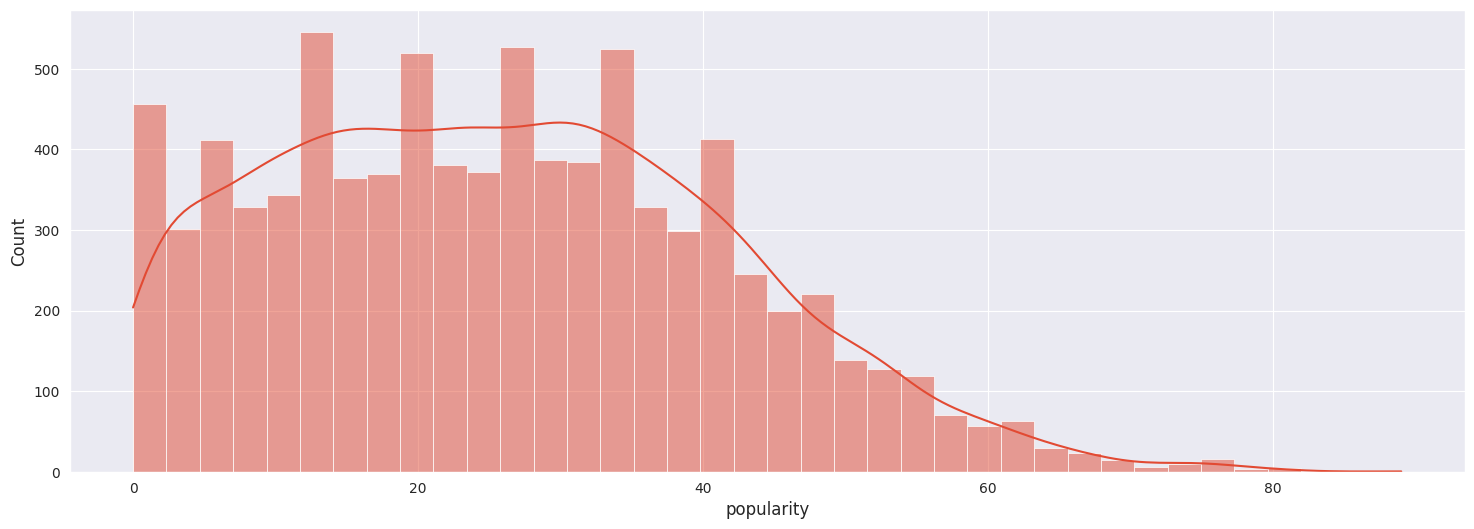

In [65]:
sns.histplot(y_train, kde=True);

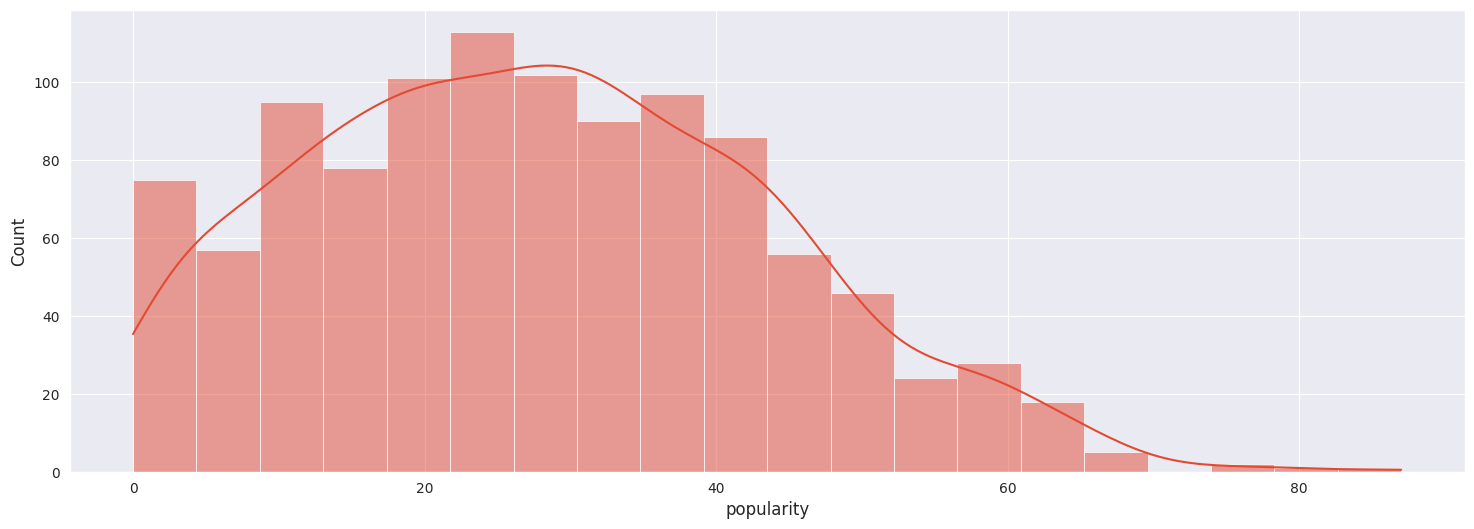

In [66]:
sns.histplot(y_val, kde=True);

## Train-Validation-Test Split: Classification

[(-0.089, 29.667], (29.667, 59.333], (59.333, 89.0]]
Categories (3, interval[float64, right]): [(-0.089, 29.667] < (29.667, 59.333] < (59.333, 89.0]]


In [79]:
print(pd.cut(audio.popularity, bins=3, right = True).unique())

audio['popularity_bins'] = pd.cut(audio.popularity, bins=3, labels = ["low", "medium", "high"], right = True
                                 )
audio['popularity_bins'].value_counts() / audio['popularity_bins'].count()

low       0.588356
medium    0.386347
high      0.025298
Name: popularity_bins, dtype: float64

In [80]:
audio.set_index('id', inplace=True)

#Audio
#X_audio_train, X_audio_temp, y_audio_train, y_audio_temp = train_test_split(audio.drop(['popularity', 'popularity_bins'], axis=1), audio.popularity_bins, stratify=audio.popularity_bins,
                                                                            #test_size=0.2, random_state=42)
#X_audio_val, X_audio_test, y_audio_val, y_audio_test = train_test_split(X_audio_temp, y_audio_temp, stratify=y_audio_temp,
                                                                        #test_size=0.5, random_state=42)

X_audio_train = audio.iloc[:int(audio.shape[0] * 0.8)].drop(['popularity', 'popularity_bins'], axis=1) #keep 80% of sorted data as train
X_audio_val = audio.iloc[int(audio.shape[0] * 0.8):int(audio.shape[0] * 0.9)].drop(['popularity', 'popularity_bins'], axis=1) # 10% validation 
X_audio_test = audio.iloc[int(audio.shape[0] * 0.9):].drop(['popularity', 'popularity_bins'], axis=1) # 10% test

#Golden Truth
y_train = audio.loc[X_audio_train.index].popularity_bins
y_val = audio.loc[X_audio_val.index].popularity_bins
y_test = audio.loc[X_audio_test.index].popularity_bins

#Genres
X_genres_train = genres.loc[X_audio_train.index] 
X_genres_val = genres.loc[X_audio_val.index] 
X_genres_test = genres.loc[X_audio_test.index] 

#Mel Spectrograms
X_mel_train = all_spectrograms.loc[X_audio_train.index]
X_mel_val = all_spectrograms.loc[X_audio_val.index]
X_mel_test = all_spectrograms.loc[X_audio_test.index]
remaining_spectrograms = all_spectrograms[~all_spectrograms.index.isin(audio.index.unique())]

#MFCCS
X_mel_features_train = mfccs.loc[X_audio_train.index]
X_mel_features_val = mfccs.loc[X_audio_val.index]
X_mel_features_test = mfccs.loc[X_audio_test.index]

In [81]:
#Delete Variables to clean up memory
del all_spectrograms, mfccs, delta_1, delta_2

### Check for correct order

In [82]:
print(X_audio_test.shape)
X_audio_test.head()

(1076, 28)


explicit  acousticness  \
id                                                                      
840588119721-6f903c10d351197af69b81cfef2c99db         0      0.000018   
190296917592-e0f460426251635a99dd5214b63124fe         1      0.008990   
190295310462-21984f57add4fa54282a8dd36cab16e8         0      0.690000   
075679862662-51c6d29d787ad6977c94eccca91bd185         0      0.025500   
840588117086-eaf5f4793a66f81e0720282eb681f11e         1      0.000111   

                                               danceability  energy  \
id                                                                    
840588119721-6f903c10d351197af69b81cfef2c99db         0.551   0.916   
190296917592-e0f460426251635a99dd5214b63124fe         0.539   0.631   
190295310462-21984f57add4fa54282a8dd36cab16e8         0.610   0.492   
075679862662-51c6d29d787ad6977c94eccca91bd185         0.428   0.861   
840588117086-eaf5f4793a66f81e0720282eb681f11e         0.398   0.961   

                                               instrumentalness  liveness  \
id                                                                          
840588119721-6f903c10d351197af69b81cfef2c99db          0.410000     0.334   
190296917592-e0f460426251635a99dd5214b63124fe          0.000000     0.132   
190295310462-21984f57add4fa54282a8dd36cab16e8          0.000055     0.123   
075679862662-51c6d29d787ad6977c94eccca91bd185          0.000102     0.116   
840588117086-eaf5f4793a66f81e0720282eb681f11e          0.000506     0.306   

                                               loudness  mode  speechiness  \
id                                                                           
840588119721-6f903c10d351197af69b81cfef2c99db    -2.540   0.0       0.0424   
190296917592-e0f460426251635a99dd5214b63124fe    -7.673   1.0       0.3930   
190295310462-21984f57add4fa54282a8dd36cab16e8    -7.198   0.0       0.0401   
075679862662-51c6d29d787ad6977c94eccca91bd185    -3.968   1.0       0.0840   
840588117086-eaf5f4793a66f81e0720282eb681f11e    -4.531   1.0       0.1850   

                                                 tempo  ...  key_2.0  key_3.0  \
id                                                      ...                     
840588119721-6f903c10d351197af69b81cfef2c99db  116.995  ...        0        0   
190296917592-e0f460426251635a99dd5214b63124fe   88.426  ...        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8  104.723  ...        0        0   
075679862662-51c6d29d787ad6977c94eccca91bd185  162.954  ...        0        0   
840588117086-eaf5f4793a66f81e0720282eb681f11e  179.042  ...        0        0   

                                               key_4.0  key_5.0  key_6.0  \
id                                                                         
840588119721-6f903c10d351197af69b81cfef2c99db        0        0        0   
190296917592-e0f460426251635a99dd5214b63124fe        0        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8        0        0        0   
075679862662-51c6d29d787ad6977c94eccca91bd185        0        0        0   
840588117086-eaf5f4793a66f81e0720282eb681f11e        0        0        0   

                                               key_7.0  key_8.0  key_9.0  \
id                                                                         
840588119721-6f903c10d351197af69b81cfef2c99db        0        0        1   
190296917592-e0f460426251635a99dd5214b63124fe        0        0        0   
190295310462-21984f57add4fa54282a8dd36cab16e8        0        0        1   
075679862662-51c6d29d787ad6977c94eccca91bd185        0        0        1   
840588117086-eaf5f4793a66f81e0720282eb681f11e        0        0        0   

                                               key_10.0  key_11.0  
id                                                                 
840588119721-6f903c10d351197af69b81cfef2c99db         0         0  
190296917592-e0f460426251635a99dd5214b63124fe         1         0  
190295310462-21984f57add4fa54282a8dd36cab16e

In [83]:
print(X_genres_test.shape)
X_genres_test.head()

(1076, 84)


first_adult  first_afro  \
id                                                                       
840588119721-6f903c10d351197af69b81cfef2c99db            0           0   
190296917592-e0f460426251635a99dd5214b63124fe            0           0   
190295310462-21984f57add4fa54282a8dd36cab16e8            0           0   
075679862662-51c6d29d787ad6977c94eccca91bd185            0           0   
840588117086-eaf5f4793a66f81e0720282eb681f11e            0           0   

                                               first_alternative  \
id                                                                 
840588119721-6f903c10d351197af69b81cfef2c99db                  1   
190296917592-e0f460426251635a99dd5214b63124fe                  0   
190295310462-21984f57add4fa54282a8dd36cab16e8                  0   
075679862662-51c6d29d787ad6977c94eccca91bd185                  1   
840588117086-eaf5f4793a66f81e0720282eb681f11e                  0   

                                               first_ambient  first_americana  \
id                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db              0                0   
190296917592-e0f460426251635a99dd5214b63124fe              0                0   
190295310462-21984f57add4fa54282a8dd36cab16e8              0                0   
075679862662-51c6d29d787ad6977c94eccca91bd185              0                0   
840588117086-eaf5f4793a66f81e0720282eb681f11e              0                0   

                                               first_asian  first_avant  \
id                                                                        
840588119721-6f903c10d351197af69b81cfef2c99db            0            0   
190296917592-e0f460426251635a99dd5214b63124fe            0            0   
190295310462-21984f57add4fa54282a8dd36cab16e8            0            0   
075679862662-51c6d29d787ad6977c94eccca91bd185            0            0   
840588117086-eaf5f4793a66f81e0720282eb681f11e            0            0   

                                               first_bluegrass  first_blues  \
id                                                                            
840588119721-6f903c10d351197af69b81cfef2c99db                0            0   
190296917592-e0f460426251635a99dd5214b63124fe                0            0   
190295310462-21984f57add4fa54282a8dd36cab16e8                0            0   
075679862662-51c6d29d787ad6977c94eccca91bd185                0            0   
840588117086-eaf5f4793a66f81e0720282eb681f11e                0            0   

                                               first_brazilian  ...  \
id                                                              ...   
840588119721-6f903c10d351197af69b81cfef2c99db                0  ...   
190296917592-e0f460426251635a99dd5214b63124fe                0  ...   
190295310462-21984f57add4fa54282a8dd36cab16e8                0  ...   
075679862662-51c6d29d787ad6977c94eccca91bd185                0  ...   
840588117086-eaf5f4793a66f81e0720282eb681f11e                0  ...   

                                               first_soundtrack  first_spoken  \
id                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db                 0             0   
190296917592-e0f460426251635a99dd5214b63124fe                 0             0   
190295310462-21984f57add4fa54282a8dd36cab16e8                 0             0   
075679862662-51c6d29d787ad6977c94eccca91bd185                 0             0   
840588117086-eaf5f4793a66f81e0720282eb681f11e                 0             0   

                                               first_stoner  first_surf  \
id                                                                        
840588119721-6f903c10d351197af69b81cfef2c99db             0           0   
190296917592-e0f460426251635a99dd5214b63124fe             0           0   
190295310462-21984f57add4fa54282a8dd3

In [84]:
print(X_mel_test.shape)
X_mel_test.head() 

(1076, 1)


mel_spectrogram
id                                                                                              
840588119721-6f903c10d351197af69b81cfef2c99db  [[-67.84694, -63.592712, -66.010506, -69.13367...
190296917592-e0f460426251635a99dd5214b63124fe  [[-29.146584, -11.293348, -6.6665864, -5.09610...
190295310462-21984f57add4fa54282a8dd36cab16e8  [[-20.936728, -15.791068, 14.598892, 24.113197...
075679862662-51c6d29d787ad6977c94eccca91bd185  [[-55.457035, -46.74417, -30.082472, -27.92501...
840588117086-eaf5f4793a66f81e0720282eb681f11e  [[-100.0, -68.58247, -60.25743, -58.777393, -5...

In [85]:
print(len(y_test))
y_test.head()

1076


id
840588119721-6f903c10d351197af69b81cfef2c99db       low
190296917592-e0f460426251635a99dd5214b63124fe    medium
190295310462-21984f57add4fa54282a8dd36cab16e8       low
075679862662-51c6d29d787ad6977c94eccca91bd185    medium
840588117086-eaf5f4793a66f81e0720282eb681f11e    medium
Name: popularity_bins, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [86]:
print(X_static_views_test.shape)
X_static_views_test.head() 

(1076, 20)


TOTAL_VIEWS__sum_values  \
id                                                                       
840588119721-6f903c10d351197af69b81cfef2c99db                 0.000014   
190296917592-e0f460426251635a99dd5214b63124fe                 0.000460   
190295310462-21984f57add4fa54282a8dd36cab16e8                 0.000013   
075679862662-51c6d29d787ad6977c94eccca91bd185                 0.000045   
840588117086-eaf5f4793a66f81e0720282eb681f11e                 0.000008   

                                               TOTAL_VIEWS__median  \
id                                                                   
840588119721-6f903c10d351197af69b81cfef2c99db             0.000016   
190296917592-e0f460426251635a99dd5214b63124fe             0.000434   
190295310462-21984f57add4fa54282a8dd36cab16e8             0.000010   
075679862662-51c6d29d787ad6977c94eccca91bd185             0.000071   
840588117086-eaf5f4793a66f81e0720282eb681f11e             0.000006   

                                               TOTAL_VIEWS__mean  \
id                                                                 
840588119721-6f903c10d351197af69b81cfef2c99db           0.000014   
190296917592-e0f460426251635a99dd5214b63124fe           0.000460   
190295310462-21984f57add4fa54282a8dd36cab16e8           0.000013   
075679862662-51c6d29d787ad6977c94eccca91bd185           0.000045   
840588117086-eaf5f4793a66f81e0720282eb681f11e           0.000008   

                                               TOTAL_VIEWS__standard_deviation  \
id                                                                               
840588119721-6f903c10d351197af69b81cfef2c99db                         0.000009   
190296917592-e0f460426251635a99dd5214b63124fe                         0.000192   
190295310462-21984f57add4fa54282a8dd36cab16e8                         0.000009   
075679862662-51c6d29d787ad6977c94eccca91bd185                         0.000036   
840588117086-eaf5f4793a66f81e0720282eb681f11e                         0.000008   

                                               TOTAL_VIEWS__variance  \
id                                                                     
840588119721-6f903c10d351197af69b81cfef2c99db           7.481268e-11   
190296917592-e0f460426251635a99dd5214b63124fe           3.689147e-08   
190295310462-21984f57add4fa54282a8dd36cab16e8           8.456084e-11   
075679862662-51c6d29d787ad6977c94eccca91bd185           1.309021e-09   
840588117086-eaf5f4793a66f81e0720282eb681f11e           6.754716e-11   

                                               TOTAL_VIEWS__root_mean_square  \
id                                                                             
840588119721-6f903c10d351197af69b81cfef2c99db                       0.000011   
190296917592-e0f460426251635a99dd5214b63124fe                       0.000332   
190295310462-21984f57add4fa54282a8dd36cab16e8                       0.000011   
075679862662-51c6d29d787ad6977c94eccca91bd185                       0.000040   
840588117086-eaf5f4793a66f81e0720282eb681f11e                       0.000008   

                                               TOTAL_VIEWS__maximum  \
id                                                                    
840588119721-6f903c10d351197af69b81cfef2c99db              0.000008   
190296917592-e0f460426251635a99dd5214b63124fe              0.000199   
190295310462-21984f57add4fa54282a8dd36cab16e8              0.000011   
075679862662-51c6d29d787ad6977c94eccca91bd185              0.000025   
840588117086-eaf5f4793a66f81e0720282eb681f11e              0.000010   

                                               TOTAL_VIEWS__absolute_maximum  \
id                                                                             
840588119721-6f903c10d351197af69b81cfef2c99db                       0.000008   
190296917592-e0f460426251635a99dd5214b63124fe                       0.000199   
190295310462-21984f57add4fa54282a8dd36cab16e8                       0.000011   
075679862662-51c6d29d

### Standardizing 
 

In [87]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [88]:
#Scale Audio Data
scaler = MinMaxScaler()
X_audio_train = pd.DataFrame(scaler.fit_transform(X_audio_train), index=X_audio_train.index, columns=X_audio_train.columns)
X_audio_val = pd.DataFrame(scaler.transform(X_audio_val), index=X_audio_val.index, columns=X_audio_val.columns)
X_audio_test = pd.DataFrame(scaler.transform(X_audio_test), index=X_audio_test.index, columns=X_audio_test.columns)

#Scale MFCCs
scaler = MinMaxScaler()
X_mel_features_train = pd.DataFrame(scaler.fit_transform(X_mel_features_train), index=X_mel_features_train.index, columns=X_mel_features_train.columns)
X_mel_features_val = pd.DataFrame(scaler.transform(X_mel_features_val), index=X_mel_features_val.index, columns=X_mel_features_val.columns)
X_mel_features_test = pd.DataFrame(scaler.transform(X_mel_features_test), index=X_mel_features_test.index, columns=X_mel_features_test.columns)

###  Train-Validation-Test Split & Standardizing (YouTube Views)

Youtube Views will be used both as static features as well as a time series. Due to the nature of their initial dataset, their split into train, validation and test will be different than the split above.

#### Static Features

In [89]:
scaler = MinMaxScaler()
kbest = SelectKBest(mutual_info_classif, k=20) #we use SelectKBest to keep feature names

pop = popularity.set_index('id')[['TOTAL_VIEWS','PEAK_VIEWS','DATE']].sort_values(by=['id','DATE']).reset_index() 
X_static_views = extract_features(pop, column_id="id", column_sort="DATE", default_fc_parameters=MinimalFCParameters())
X_static_views = X_static_views.replace([np.inf, -np.inf], np.nan).dropna(axis=1).reset_index().rename({'index' : 'id'},axis=1).merge(trends, on='id', how='left').set_index('id')

X_static_views_train = pd.DataFrame(kbest.fit_transform(X_static_views.loc[X_audio_train.index], y_train), 
                                    index=X_static_views.loc[X_audio_train.index].index, 
                                    columns=X_static_views.loc[X_audio_train.index].columns[kbest.get_support(1)]) 
X_static_views_train = pd.DataFrame(scaler.fit_transform(X_static_views_train), index=X_static_views_train.index, columns=X_static_views_train.columns)

X_static_views_val = pd.DataFrame(kbest.transform(X_static_views.loc[X_audio_val.index]), 
                                  index=X_static_views.loc[X_audio_val.index].index, 
                                  columns=X_static_views.loc[X_audio_val.index].columns[kbest.get_support(1)]) 
X_static_views_val = pd.DataFrame(scaler.transform(X_static_views_val), index=X_static_views_val.index, columns=X_static_views_val.columns)

X_static_views_test = pd.DataFrame(kbest.transform(X_static_views.loc[X_audio_test.index]), 
                                   index=X_static_views.loc[X_audio_test.index].index, 
                                   columns=X_static_views.loc[X_audio_test.index].columns[kbest.get_support(1)]) 
X_static_views_test = pd.DataFrame(scaler.transform(X_static_views_test), index=X_static_views_test.index, columns=X_static_views_test.columns)

Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.91it/s]


In [90]:
X_static_views_train.columns

Index(['TOTAL_VIEWS__sum_values', 'TOTAL_VIEWS__median', 'TOTAL_VIEWS__mean',
       'TOTAL_VIEWS__standard_deviation', 'TOTAL_VIEWS__variance',
       'TOTAL_VIEWS__root_mean_square', 'TOTAL_VIEWS__maximum',
       'TOTAL_VIEWS__absolute_maximum', 'TOTAL_VIEWS__minimum',
       'PEAK_VIEWS__sum_values', 'PEAK_VIEWS__median', 'PEAK_VIEWS__mean',
       'PEAK_VIEWS__standard_deviation', 'PEAK_VIEWS__variance',
       'PEAK_VIEWS__root_mean_square', 'PEAK_VIEWS__maximum',
       'PEAK_VIEWS__absolute_maximum', 'TOTAL_VIEWS_coef', 'PEAK_VIEWS_coef',
       'TOTAL_VIEWS_coef_12'],
      dtype='object')

#### Time Series  

In [92]:
scaler = StandardScaler()

train_pop = popularity.set_index('id').loc[X_audio_train.index][['TOTAL_VIEWS','PEAK_VIEWS','DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
train_pop = pd.DataFrame(scaler.fit_transform(train_pop),  index=train_pop.index, columns=train_pop.columns)
X_views_train = pd.DataFrame(index = train_pop.index.unique()).reset_index()
X_views_train['TOTAL_VIEWS'] = train_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_train['PEAK_VIEWS'] = train_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_train['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_train.TOTAL_VIEWS, X_views_train.PEAK_VIEWS)]

val_pop = popularity.set_index('id').loc[X_audio_val.index][['TOTAL_VIEWS','PEAK_VIEWS', 'DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
val_pop = pd.DataFrame(scaler.transform(val_pop),  index=val_pop.index, columns=val_pop.columns)
X_views_val = pd.DataFrame(index = val_pop.index.unique()).reset_index()
X_views_val['TOTAL_VIEWS'] = val_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_val['PEAK_VIEWS'] = val_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_val['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_val.TOTAL_VIEWS, X_views_val.PEAK_VIEWS)]

test_pop = popularity.set_index('id').loc[X_audio_test.index][['TOTAL_VIEWS','PEAK_VIEWS', 'DATE']].sort_values(by=['id','DATE']).drop('DATE', axis=1)
test_pop = pd.DataFrame(scaler.transform(test_pop),  index=test_pop.index, columns=test_pop.columns)
X_views_test = pd.DataFrame(index = test_pop.index.unique()).reset_index()
X_views_test['TOTAL_VIEWS'] = test_pop.groupby(['id'])['TOTAL_VIEWS'].apply(lambda x: np.array(x)).values
X_views_test['PEAK_VIEWS'] = test_pop.groupby(['id'])['PEAK_VIEWS'].apply(lambda x: np.array(x)).values
X_views_test['VIEWS'] = [np.array([x, y]) for x, y in zip(X_views_test.TOTAL_VIEWS, X_views_test.PEAK_VIEWS)]

In [93]:
#Fix order of songs
X_views_train = X_audio_train.merge(X_views_train, on='id', how='left')[['id', 'VIEWS']]
X_views_train = np.array([x for x in X_views_train.VIEWS]).transpose((0,2,1)).reshape(X_views_train.shape[0], 41, 2)

X_views_val = X_audio_val.merge(X_views_val, on='id', how='left')[['id', 'VIEWS']]
X_views_val = np.array([x for x in X_views_val.VIEWS]).transpose((0,2,1)).reshape(X_views_val.shape[0], 41, 2)

X_views_test = X_audio_test.merge(X_views_test, on='id', how='left')[['id', 'VIEWS']]
X_views_test = np.array([x for x in X_views_test.VIEWS]).transpose((0,2,1)).reshape(X_views_test.shape[0], 41, 2)

### Save Data 

In [94]:
with open('spotify_features_cl.pkl', 'wb') as h:
    pickle.dump([X_audio_train.astype(np.float32), X_audio_val.astype(np.float32), X_audio_test.astype(np.float32)], h)

with open('genres_cl.pkl', 'wb') as h:
    pickle.dump([X_genres_train, X_genres_val, X_genres_test], h)
    
with open('mel_spectrograms_cl.pkl', 'wb') as h:
    pickle.dump([X_mel_train, X_mel_val, X_mel_test], h)

with open('mfccs_cl.pkl', 'wb') as h:
    pickle.dump([X_mel_features_train, X_mel_features_val, X_mel_features_test], h)
    
with open('target_cl.pkl','wb') as h:
    pickle.dump([y_train, y_val, y_test], h)

In [95]:
with open('youtube_views_cl.pkl', 'wb') as h:
    pickle.dump([X_views_train, X_views_val, X_views_test], h)
    
with open('static_views_cl.pkl', 'wb') as h:
    pickle.dump([X_static_views_train.astype(np.float32), X_static_views_val.astype(np.float32), X_static_views_test.astype(np.float32)], h)

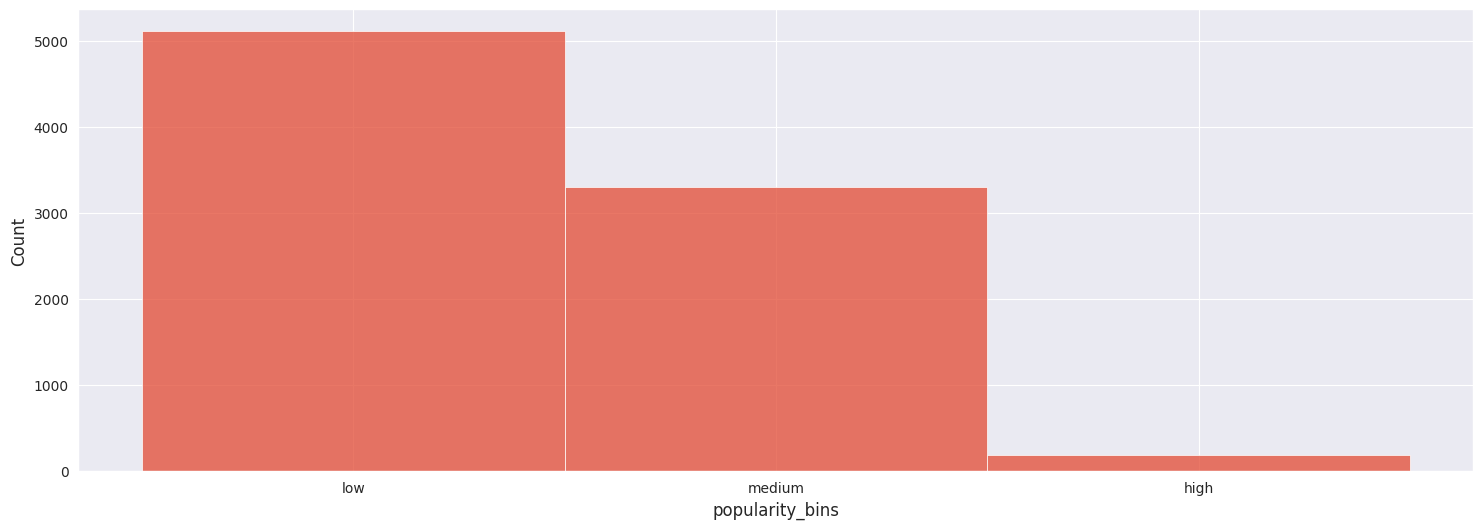

In [96]:
sns.histplot(y_train);

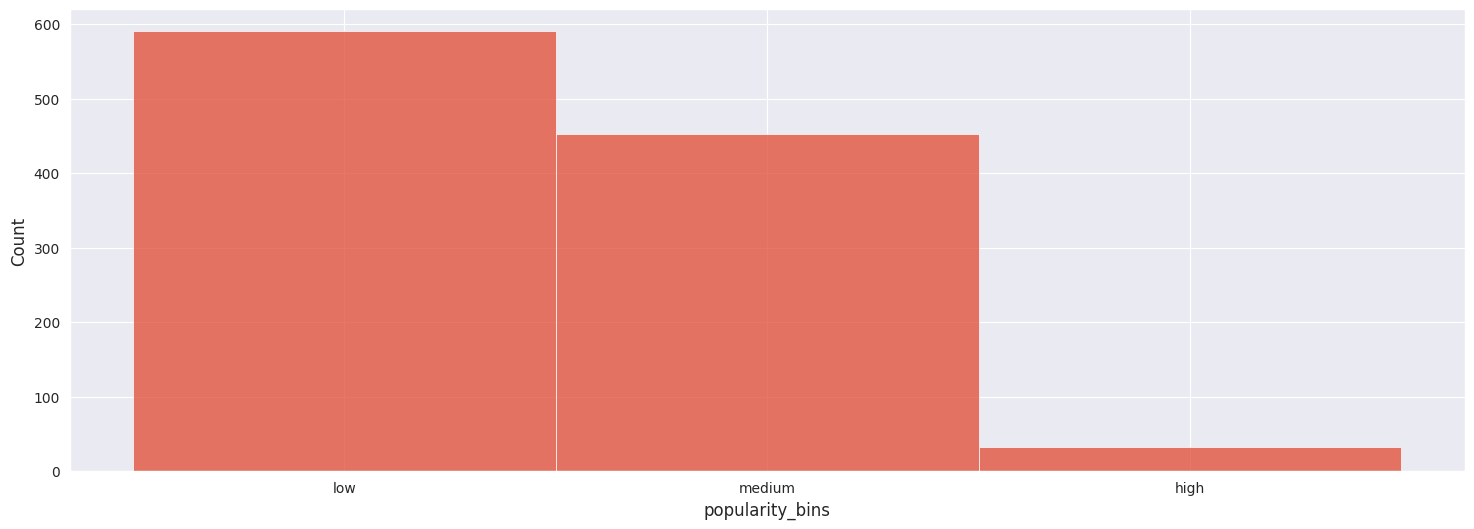

In [97]:
sns.histplot(y_val);

In [98]:
audio['popularity_bins'].value_counts() / audio['popularity_bins'].count()

low       0.588356
medium    0.386347
high      0.025298
Name: popularity_bins, dtype: float64

In [100]:
y_train.value_counts() / y_train.count()

low       0.593536
medium    0.384141
high      0.022323
Name: popularity_bins, dtype: float64

In [101]:
y_val.value_counts() / y_val.count()

low       0.548837
medium    0.420465
high      0.030698
Name: popularity_bins, dtype: float64

In [102]:
y_test.value_counts() / y_test.count()

low       0.586431
medium    0.369888
high      0.043680
Name: popularity_bins, dtype: float64